<div style="background-color:#f2f2f2; padding: 20px;">
    <p style="border-radius:10px; border:#DEB887 solid; padding:25px; background-color: #FFFAF0; font-size:200%;color:#52017A;text-align:center;">PROJECT UAS - ANALISIS DERET & WAKTU</p>
      <P style="color:#333; text-align:center; font-family:Arial, sans-serif; border-bottom: 2px solid #ccc; padding-bottom: 10px;">
    MODEL: ARIMA - SARIMA - SARIMAX - TIME SERIES REGRESSION
  </P>
</div>

# Library yang dibutuhkan

In [43]:
import pandas as pd
import numpy as np
from datetime import datetime

from IPython.display import display
from PIL import Image


import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt


# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
sns.set_style('darkgrid')
sns.set(color_codes=True)

In [44]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [45]:
def find_outliers(df):
    outliers_data = []

    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_fence = Q1 - 1.5 * IQR
            upper_fence = Q3 + 1.5 * IQR
            column_outliers = df[(df[column] < lower_fence) | (df[column] > upper_fence)]

            outliers_data.append({
                "Nama Kolom": column,
                "Outliers Count": len(column_outliers),
            })

    outliers_df = pd.DataFrame(outliers_data)
    outliers_df = outliers_df.sort_values('Outliers Count', ascending=False)
    
    return outliers_df

# Meta Data

📌 https://www.kaggle.com/datasets/ucsandiego/carbon-dioxide/data

Catatan karbon dioksida dari Observatorium Mauna Loa, yang dikenal sebagai “Kurva Keeling,” adalah rekor konsentrasi karbon dioksida atmosfer terpanjang yang tak terpecahkan di dunia. Para ilmuwan melakukan pengukuran atmosfer di lokasi terpencil untuk mengambil sampel udara yang mewakili sejumlah besar atmosfer bumi dan relatif bebas dari pengaruh lokal.

CO2 di atmosfer dari Sampel Udara Berkelanjutan di Observatorium Mauna Loa, Hawaii, AS. Periode Pencatatan: Maret 1958 - Desember 2017

<blockquote> Context </blockquote>
Catatan karbon dioksida dari Observatorium Mauna Loa, yang dikenal sebagai “Kurva Keeling,” adalah rekor konsentrasi karbon dioksida atmosfer terpanjang yang tak terpecahkan di dunia. Para ilmuwan melakukan pengukuran atmosfer di lokasi terpencil untuk mengambil sampel udara yang mewakili sejumlah besar atmosfer bumi dan relatif bebas dari pengaruh lokal.

<blockquote> Content </blockquote>
Kumpulan data ini mencakup pengamatan bulanan konsentrasi karbon dioksida (atau CO2) di atmosfer dari Observatorium Mauna Loa (Hawaii) pada garis lintang 19,5, garis bujur -155,6, dan ketinggian 3397 meter.

- **Columns 1-3**: Provide the date in the following redundant formats: year, month, and decimal date
- **Column 4**: Monthly CO2 concentrations in parts per million (ppm) measured on the 08A calibration scale and collected at 24:00 hours on the fifteenth of each month.
- **Column 5**: The fifth column provides the same data after a seasonal adjustment, which involves subtracting from the data a 4-harmonic fit with a linear gain factor to remove the seasonal cycle from carbon dioxide measurements
- **Column 6**: The sixth column provides the data with noise removed, generated from a stiff cubic spline function plus 4-harmonic functions with linear gain
- **Column 7**: The seventh column is the same data with the seasonal cycle removed.

<blockquote> Acknowledgements </blockquote>
Data karbon dioksida dikumpulkan dan diterbitkan oleh Scripps Institution of Oceanography Universitas California di bawah pengawasan Charles David Keeling dengan dukungan dari Departemen Energi AS, Jaringan Bumi, dan National Science Foundation.

<blockquote> Inspiration </blockquote>

- How have atmospheric carbon dioxide levels changed in the past sixty years?
- How do carbon dioxide concentrations change seasonally?
- What causes this seasonal cycle?
- When will the carbon dioxide levels exceed 450 parts per million?

# Import and Explore Data

In [46]:
df = pd.read_csv("data/archive.csv", parse_dates= {"Date" : ["Year","Month"]}) # read in the data

In [47]:
df.head(5)

,Date,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
0,1958-01-01,1958.0411,NaN,NaN,NaN,NaN
1,1958-02-01,1958.1260,NaN,NaN,NaN,NaN
2,1958-03-01,1958.2027,315.6900,314.4200,316.1800,314.8900
3,1958-04-01,1958.2877,317.4500,315.1500,317.3000,314.9800
4,1958-05-01,1958.3699,317.5000,314.7300,317.8300,315.0600


In [48]:
df.drop(columns = ['Carbon Dioxide Fit (ppm)', 'Seasonally Adjusted CO2 Fit (ppm)','Seasonally Adjusted CO2 (ppm)'], inplace = True)

## Cek Outlier

In [49]:
find_outliers(df)

,Nama Kolom,Outliers Count
0,Decimal Date,0
1,Carbon Dioxide (ppm),0


## Check Missing Value

In [50]:
missing_data(df)

,Total,Percent
Carbon Dioxide (ppm),17,2.3611
Date,0,0.0000
Decimal Date,0,0.0000


In [51]:
df.duplicated().sum()

0

## Check Informasi Data

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  720 non-null    datetime64[ns]
 1   Decimal Date          720 non-null    float64       
 2   Carbon Dioxide (ppm)  703 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 17.0 KB


In [53]:
df.describe()

,Decimal Date,Carbon Dioxide (ppm)
count,720.0000,703.0000
mean,1987.9975,352.3756
std,17.3325,26.2419
min,1958.0411,313.2100
25%,1973.0199,328.5550
50%,1987.9986,349.8000
75%,2002.9774,373.1950
max,2017.9562,407.6500


# Data Preprocessing

## remove any NaN data

In [54]:
# remove any NaN data
df = df.dropna(how='any', subset=['Carbon Dioxide (ppm)'])

In [55]:
missing_data(df)

,Total,Percent
Date,0,0.0000
Decimal Date,0,0.0000
Carbon Dioxide (ppm),0,0.0000


In [56]:
df.sample(4)

,Date,Decimal Date,Carbon Dioxide (ppm)
519,2001-04-01,2001.2877,372.8700
326,1985-03-01,1985.2027,347.4300
410,1992-03-01,1992.2049,357.8100
21,1959-10-01,1959.7890,313.3400


## Plot the data yang digunakan

https://www.kaggle.com/code/carlmcbrideellis/time-series-decomposition-naive-example

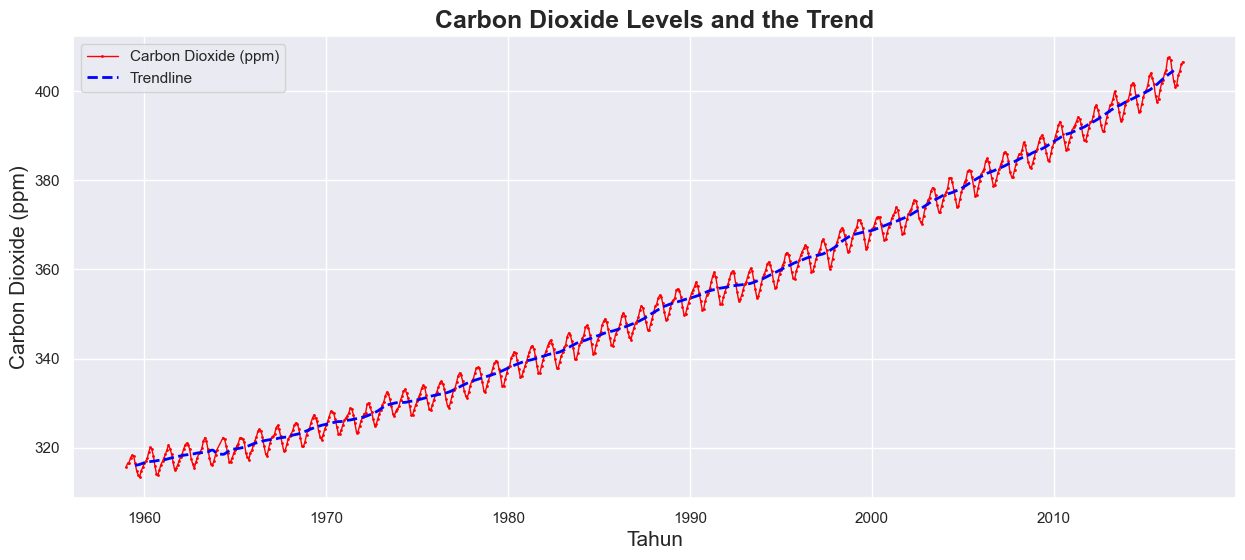

In [57]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Melakukan dekomposisi musiman
additiveDecomposition = seasonal_decompose(df['Carbon Dioxide (ppm)'].iloc[8:], model='additive', period=12)

# Plot data aktual
plt.figure(figsize=(15, 6))

plt.plot(df['Date'].iloc[8:], df['Carbon Dioxide (ppm)'].iloc[8:], label='Carbon Dioxide (ppm)', marker='o', markersize=1 , linewidth=1, linestyle='-', color = 'Red')

plt.plot(df['Date'].iloc[8:], additiveDecomposition.trend,label='Trendline', linestyle='--', lw=2, color='blue')


plt.title('Carbon Dioxide Levels and the Trend', fontdict={'fontsize':18}, fontweight ='bold')
plt.xlabel('Tahun', fontdict={'fontsize':15})
plt.ylabel('Carbon Dioxide (ppm)', fontdict={'fontsize':15})
plt.legend()
plt.grid(True)

plt.show()

"Time series decomposition" dalam bahasa Indonesia dapat diterjemahkan sebagai "dekomposisi deret waktu". Ini merujuk pada teknik untuk memecah dataset deret waktu menjadi komponen-komponen individu, seperti tren, musiman, dan noise (sisa atau residu), guna memahami pola dan struktur yang ada dalam data deret waktu tersebut. 

Ada dua metode umum dalam dekomposisi deret waktu:

1. **Dekomposisi Additif:**
   Dalam dekomposisi additif, sebuah deret waktu ($ y(t) $) didekomposisi menjadi komponen-komponennya dengan asumsi bahwa nilai-nilai yang diamati adalah jumlah dari komponen tren, komponen musiman, dan komponen sisa pada waktu ($ t $):
   $y(t) = \text{Tren}(t) + \text{Musiman}(t) + \text{Sisa}(t)$

2. **Dekomposisi Multiplikatif:**
   Dalam dekomposisi multiplikatif, sebuah deret waktu ($ y(t) $) didekomposisi dengan asumsi bahwa nilai-nilai yang diamati adalah hasil kali dari komponen tren, komponen musiman, dan komponen sisa pada waktu ($ t $):
   $y(t) = \text{Tren}(t) \times \text{Musiman}(t) \times \text{Sisa}(t)$

Dekomposisi deret waktu biasanya melibatkan penggunaan teknik statistik atau fungsi-fungsi khusus yang tersedia dalam perpustakaan seperti `statsmodels` dalam bahasa pemrograman Python. Teknik ini membantu dalam memahami pola-pola yang mendasari data deret waktu, yang kemudian dapat digunakan untuk analisis lebih lanjut, peramalan, dan pemodelan data deret waktu tersebut.

## Cek Trend

### Bulan

In [58]:
df2 = df.copy()

df2.set_index('Date', inplace = True)

df2['Tahun'] = df2.index.year
df2['Bulan'] = df2.index.month_name()
df2['Hari'] = df2.index.day_name()
df2['Tanggal'] = df2.index.day

In [59]:
df2.reset_index(inplace = True)

In [60]:
awal = '1959-01-01'
akhir = '2016-12-01'
df2 = df2.loc[(df2['Date'] >= awal) & (df2['Date'] <= akhir)]  

In [61]:
df2 = df2.reset_index(drop = True)

In [62]:
df2.sample(3)

,Date,Decimal Date,Carbon Dioxide (ppm),Tahun,Bulan,Hari,Tanggal
379,1990-11-01,1990.8740,352.8300,1990,November,Thursday,1
259,1980-11-01,1980.8743,337.1000,1980,November,Saturday,1
645,2013-01-01,2013.0411,395.6100,2013,January,Tuesday,1


In [63]:
dataframe_bulan = df2[['Bulan','Carbon Dioxide (ppm)','Tahun']]
dataframe_bulan.sample(3)

,Bulan,Carbon Dioxide (ppm),Tahun
127,November,322.8500,1969
500,December,369.5300,2000
38,March,319.6800,1962


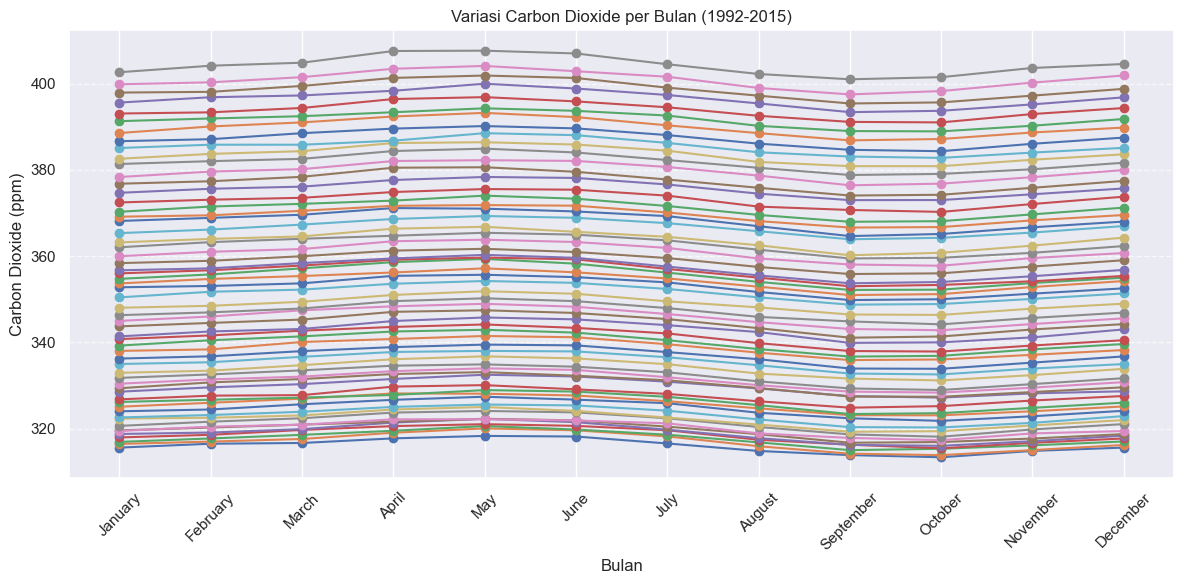

In [64]:
# Membuat plot
plt.figure(figsize=(12, 6))

# Memisahkan data berdasarkan tahun
for tahun, group in dataframe_bulan.groupby('Tahun'):
    plt.plot(group['Bulan'], group['Carbon Dioxide (ppm)'], label=str(tahun), marker='o')

plt.xlabel('Bulan')
plt.ylabel('Carbon Dioxide (ppm)')
plt.title('Variasi Carbon Dioxide per Bulan (1992-2015)')
plt.xticks(rotation=45)
# plt.legend(title='Tahun', loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()

## Now let's superimpose the overall trend on top of the original data

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
additiveDecomposition = seasonal_decompose(df['Carbon Dioxide (ppm)'], model='additive', period=12)

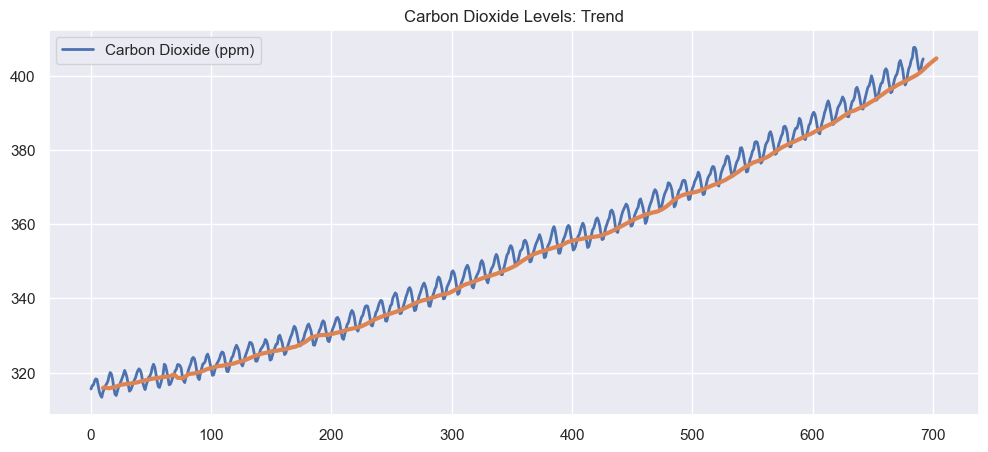

In [66]:
df2.plot(y='Carbon Dioxide (ppm)', kind='line',figsize=(12,5), lw=2, title="Carbon Dioxide Levels: Trend")
additiveDecomposition.trend.plot(kind='line',figsize=(12,5), lw=3);

disini datanya konstan, variasinya relatif tetap tapi memang ada tren dan menaik.

In [67]:
missing_data(df2)

,Total,Percent
Date,0,0.0000
Decimal Date,0,0.0000
Carbon Dioxide (ppm),0,0.0000
Tahun,0,0.0000
Bulan,0,0.0000
Hari,0,0.0000
Tanggal,0,0.0000


# Decompose Data

Fungsi `ts_decompose()` yang Anda tunjukkan adalah sebuah fungsi dalam Python yang bertujuan untuk melakukan dekomposisi data deret waktu menjadi komponen-komponen utama, yaitu tren, musiman, dan residu. Berikut adalah penjelasan dari fungsi ini:

1. **Stationary Test (Pengujian Stasioneritas)**:
   - Fungsi pertama yang dilakukan adalah pengujian stasioneritas menggunakan tes Dickey-Fuller (`sm.tsa.stattools.adfuller(y)[1]`). Tes ini memeriksa apakah data deret waktu stasioner atau tidak. 
   - Jika nilai p-value yang dihasilkan dari tes Dickey-Fuller kurang dari 0.05, maka hipotesis nol (H0) yang menyatakan bahwa data tidak stasioner ditolak, dan data cenderung stasioner. Jika nilainya lebih besar dari 0.05, data cenderung tidak stasioner.

2. **Decomposition Plot (Grafik Dekomposisi)**:
   - Fungsi kemudian melakukan dekomposisi menggunakan fungsi `seasonal_decompose()` untuk memisahkan data menjadi komponen-komponen: tren, komponen musiman, dan residu.
   - Dilakukan pembuatan subplot menggunakan `plt.subplots()` untuk menampilkan komponen-komponen tersebut dalam grafik yang terpisah.
   - Empat subplot ditampilkan:
     - **Original Data Plot (Grafik Data Asli)**: Menunjukkan data deret waktu asli.
     - **Trend Plot (Grafik Tren)**: Menunjukkan tren dalam data.
     - **Seasonality Plot (Grafik Musiman)**: Menunjukkan komponen musiman.
     - **Residuals Plot (Grafik Sisa/Residu)**: Menunjukkan sisa dari dekomposisi data, yang diharapkan tidak memiliki pola atau struktur tertentu.

Pengaruh dari fungsi ini terhadap data adalah memberikan pemahaman visual tentang komponen-komponen utama dalam data deret waktu Anda, yaitu tren, musiman, dan sisa (residu). Ini dapat membantu dalam analisis untuk memahami pola, perilaku, atau fluktuasi dalam data yang mungkin tidak terlihat secara langsung dalam data aslinya. Selain itu, pengujian stasioneritas juga memberikan informasi penting tentang sifat data yang akan digunakan dalam analisis lebih lanjut, terutama dalam konteks pemodelan deret waktu.

In [68]:
p_value = sm.tsa.stattools.adfuller(df2['Carbon Dioxide (ppm)'])
# p_value

Dickey-Fuller - Komponen:

```python
Test Statistic: 4.237031959886757
p-value: 1.0
Lags Used: 18
Number of Observations Used: 674
Critical Values for the test statistic at 1%, 5%, and 10%:
1%: -3.4400894360545475
5%: -2.865837730028723
10%: -2.5690586760471605
Maximized Information Criterion (aic): 714.3200138382199
```

# Uji Dickey-Fuller dan Decomposisi Data

Setelah dilakukan Dickey Fuller, maka didapatkan bahwa data yang digunakan tidak stationer. diperlukan Diff untuk menjadikan data stationer

- additive suatu musiman yang sifatnya lebih ke konstan dan ada trend
- multiplikastif dia ada tren tpi musimannya makin lama makin besar

In [69]:
def ts_decompose(y, model="additive"):
    
    # Stationary Test: Dickey-Fuller
    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        is_istationary = (F"Result: [Tolak H0] Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        is_istationary = (F"Result: [Terima H0] Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    
    print("Dickey-Fuller Test Results:")
    print(is_istationary)
    
    result = seasonal_decompose(y, model=model, period=12)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].set_title(is_istationary)
    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

1. Original Data Plot (Grafik Data Asli): Menunjukkan data deret waktu asli.
2. Trend Plot (Grafik Tren): Menunjukkan tren dalam data.
3. Seasonality Plot (Grafik Musiman): Menunjukkan komponen musiman.
4. Residuals Plot (Grafik Sisa/Residu): Menunjukkan sisa dari dekomposisi data, yang diharapkan tidak memiliki pola atau struktur tertentu.

Dickey-Fuller Test Results:
Result: [Terima H0] Non-Stationary (H0: non-stationary, p-value: 1.0)


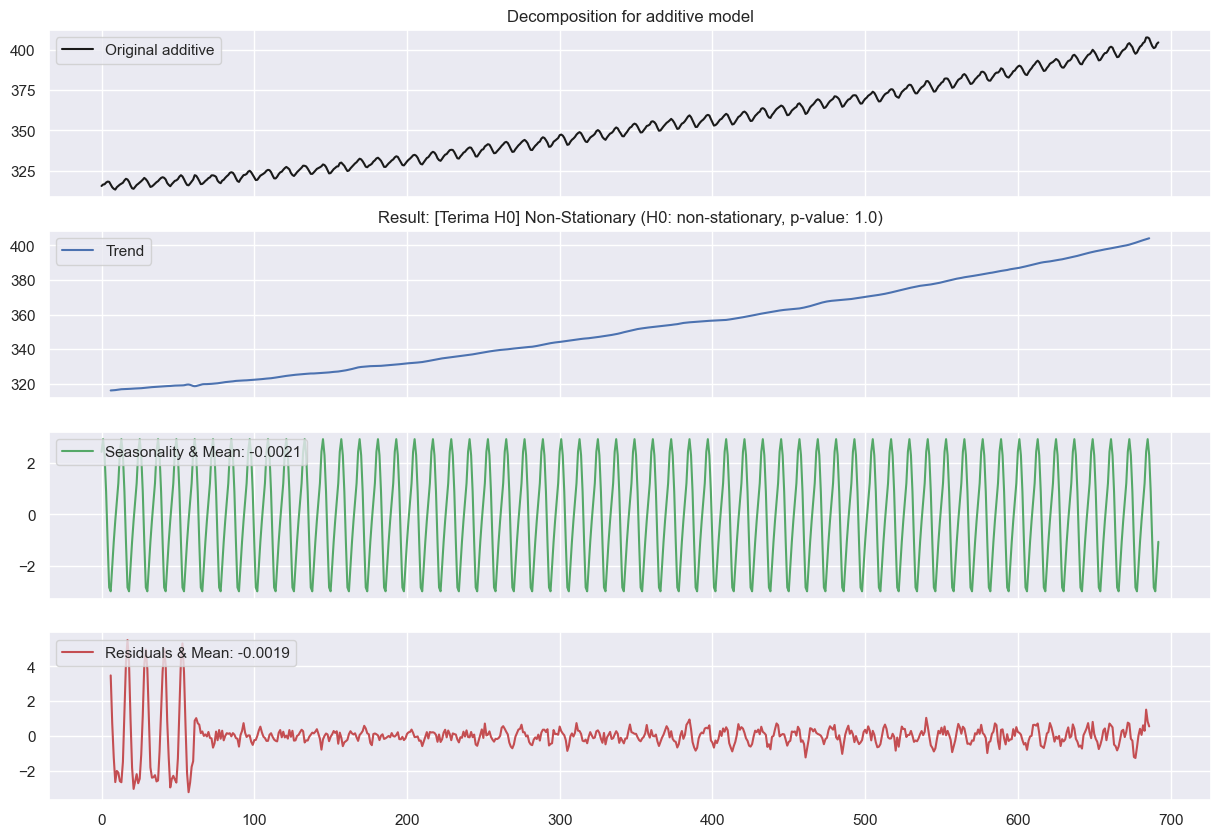

In [70]:
ts_decompose(df2['Carbon Dioxide (ppm)'])

gambar 3(yang hijau) itu menunjukkan varians rata2 konstan. jadi sesaui denagn penggunaan model additive nya

original adittive / Yt= Trendt+ Seasonal+ Residual

# Differencing Data

### Dari uji ADF ini ditemukan bahwa Terima H-0 yang berrti data kita adalah data tidak Stationer.

<blockquote> Data Perlu Differencing </blockquote>

Differencing non musiman berarti, cukup menggunakan $z_t=y_t-y_{t-1}$

Differencing musiman, menggunakan $z_t=y_t-{y-t_(12))}$

In [71]:
df2.sample(2)

,Date,Decimal Date,Carbon Dioxide (ppm),Tahun,Bulan,Hari,Tanggal
117,1969-01-01,1969.0411,324.0000,1969,January,Wednesday,1
488,1999-12-01,1999.9562,368.0100,1999,December,Wednesday,1


In [72]:
df2['Carbon Dioxide (ppm)_Diff [1kali]'] = df2['Carbon Dioxide (ppm)'].diff(1) # Diff untuk Non Seasonal Model
df2['Carbon Dioxide (ppm)_Diff-12'] = df2['Carbon Dioxide (ppm)'].diff(1).diff(12) # Diff untuk Seasonal Model

In [73]:
df2.sample(3)

,Date,Decimal Date,Carbon Dioxide (ppm),Tahun,Bulan,Hari,Tanggal,Carbon Dioxide (ppm)_Diff [1kali],Carbon Dioxide (ppm)_Diff-12
176,1973-12-01,1973.9562,328.6400,1973,December,Saturday,1,0.4800,-0.5700
664,2014-08-01,2014.6219,397.2100,2014,August,Friday,1,-1.8600,0.1000
225,1978-01-01,1978.0411,334.9700,1978,January,Sunday,1,1.1200,-0.1300


# Uji Stationeritas Setelah Differencing
H0 : Data Tidak Staioner

H1 : Data Stationer
    
Daerah PENOLAKAN:
jika p-value < 0.05 (alpha) maka tolak HO

In [74]:
# SARIMA

In [75]:
from statsmodels.tsa.stattools import adfuller

# Lakukan uji Dickey-Fuller untuk data time series
# df2['Carbon Dioxide (ppm)_Diff-12'] adalah kolom yang ingin diuji
# iloc[13:] digunakan untuk membuang nilai NaN yang muncul karena differencing
residual_check = adfuller(df2['Carbon Dioxide (ppm)_Diff-12'].iloc[13:], autolag='AIC')

# Periksa apakah p-value kurang dari alpha (biasanya 0.05)
alpha = 0.05
if residual_check[1] < alpha:
    print(residual_check[1] , "<", alpha, "- H0 ditolak. Data Stationer.")
else:
    print("Tidak cukup bukti untuk menolak H0. Data tidak Stationer.")
    
print('Carbon Dioxide (ppm)_Diff-12')

1.4979527869017787e-13 < 0.05 - H0 ditolak. Data Stationer.
Carbon Dioxide (ppm)_Diff-12


In [76]:
# ARIMA

In [77]:
from statsmodels.tsa.stattools import adfuller

# Lakukan uji Dickey-Fuller untuk data time series
# df2['Carbon Dioxide (ppm)_Diff-12'] adalah kolom yang ingin diuji
# iloc[13:] digunakan untuk membuang nilai NaN yang muncul karena differencing
residual_check = adfuller(df2['Carbon Dioxide (ppm)_Diff [1kali]'].iloc[1:], autolag='AIC')

# Periksa apakah p-value kurang dari alpha (biasanya 0.05)
alpha = 0.05
if residual_check[1] < alpha:
    print(residual_check[1] , "<", alpha, "- H0 ditolak. Data Stationer.")
else:
    print("Tidak cukup bukti untuk menolak H0. Data tidak Stationer.")
    
print('Carbon Dioxide (ppm)_Diff [2kali]')

0.001134229808925368 < 0.05 - H0 ditolak. Data Stationer.
Carbon Dioxide (ppm)_Diff [2kali]


# Split Data to Train & Test

https://www.comet.com/site/blog/understanding-hold-out-methods-for-training-machine-learning-models/#:~:text=The%20hold%2Dout%20method%20involves,both%20model%20evaluation%20and%20selection.

Metode hold-out melibatkan pemisahan data menjadi beberapa bagian dan menggunakan satu bagian untuk melatih model dan sisanya untuk memvalidasi dan mengujinya. Ini dapat digunakan untuk evaluasi dan pemilihan model.

In [78]:
from datetime import datetime

# Tanggal rentang Data Train dan Data Test
train_start_date = datetime.strptime('1959-01-01', '%Y-%m-%d')
train_end_date = datetime.strptime('2005-01-01', '%Y-%m-%d')
test_start_date = datetime.strptime('2005-01-01', '%Y-%m-%d')
test_end_date = datetime.strptime('2016-12-01', '%Y-%m-%d')

# Menghitung selisih tahun untuk Data Train dan Data Test
years_train = train_end_date.year - train_start_date.year
years_test = test_end_date.year - test_start_date.year

print(f"Data Train memiliki rentang waktu dari {train_start_date} hingga {train_end_date} yang berarti selama {years_train} tahun.")
print(f"Data Test memiliki rentang waktu dari {test_start_date} hingga {test_end_date} yang berarti {years_test} tahun.")

Data Train memiliki rentang waktu dari 1959-01-01 00:00:00 hingga 2005-01-01 00:00:00 yang berarti selama 46 tahun.
Data Test memiliki rentang waktu dari 2005-01-01 00:00:00 hingga 2016-12-01 00:00:00 yang berarti 11 tahun.


- <blockquote>Untuk Data Train: </blockquote>

***`46 tahun`***

- <blockquote>Untuk Data Test:</blockquote>

***`11 tahun`***

In [79]:
def hitung_nilai_persen(nilai, persen):
    """Fungsi untuk menghitung nilai dari persentase tertentu dari suatu angka."""
    nilai_persen = (persen / 100) * nilai
    return nilai_persen

# Contoh penggunaan fungsi untuk mencari nilai dari 30% dari angka 703
angka = 703
persen = 20
hasil = hitung_nilai_persen(angka, persen)
print(f"{persen}% dari {angka} adalah {hasil}")

20% dari 703 adalah 140.6


In [80]:
# Using Holdut Method ===> Train: 549 Month and Test: 144 Month 
# proporsi (+-) 20% data test & 70% data train
# Membagi data menjadi data pelatihan (train) dan data uji (test) berdasarkan tanggal

# Memilih data pelatihan (train) & data uji (test) berdasarkan rentang tanggal
train_start_date = '1959-01-01'
train_end_date = '2005-01-01'
test_start_date = '2005-01-01'
test_end_date = '2016-12-01'

train = df2.loc[(df2['Date'] >= train_start_date) & (df2['Date'] < train_end_date)]  
test = df2[(df2['Date'] >= test_start_date) & (df2['Date'] <= test_end_date)]

print("Jumlah data dalam keseluruhan:", len(df2))
print("Jumlah data dalam set pelatihan:", len(train))
print("Jumlah data dalam set uji:", len(test))
print("Jumlah data yang tidak dipakai:", len(df2) - (len(train) + len(test)))
print("-"*50)
print(f"Data Train dari tanggal: {train_start_date} - {train_end_date}")
print(f"Data Test dari tanggal: {test_start_date} - {test_end_date}")

Jumlah data dalam keseluruhan: 693
Jumlah data dalam set pelatihan: 549
Jumlah data dalam set uji: 144
Jumlah data yang tidak dipakai: 0
--------------------------------------------------
Data Train dari tanggal: 1959-01-01 - 2005-01-01
Data Test dari tanggal: 2005-01-01 - 2016-12-01


# Plot ACF & PACF  : Correlograms

Dalam tabel di bawah ini dijelaskan karakteristik dari model ARIMA (termasuk AR, MA, dan kombinasi ARMA) beserta interpretasi dari pola yang umum terjadi pada Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF):

| Model        | ACF            | PACF          | Deskripsi                                                   |
|:--------------|:----------------|:---------------|:-------------------------------------------------------------|
| MA(q)        | Cuts off       | Dies down     | Moving Average of order q. Cuts off after lag q.             |
| AR(p)        | Dies down      | Cuts off      | Autoregressive of order p. Dies down after lag p.            |
| ARMA(p,q)    | Dies down      | Dies down     | Mixed Autoregressive Moving Average of order (p, q).         |
| AR(p) or MA(q) | Cuts off     | Cuts off      | Cuts off after lag q for MA(q), after lag p for AR(p).       |
| No order (White Noise or Random) | No spike | No spike   | Tidak ada pola khusus yang terlihat pada ACF dan PACF.      |

Tabel ini memberikan panduan umum tentang bagaimana pola ACF dan PACF berperilaku pada model-model ARIMA yang berbeda. Hal ini membantu dalam menentukan nilai p (order AR), q (order MA), atau kombinasi keduanya untuk model ARIMA yang sesuai dengan data time series yang sedang dianalisis.

Autocorrelogram & Partail Autocorrelogram is useful that to estimate each models parametaers.

MA itu di ACF, AR nya di PACF

`p - > AR - > PACF`
`q - > MA - > ACF`

## diff 1 untuk non seasonal (ARIMA)

- https://www.youtube.com/watch?v=CAT0Y66nPhs
- https://www.youtube.com/watch?v=wfDstwTdoxU

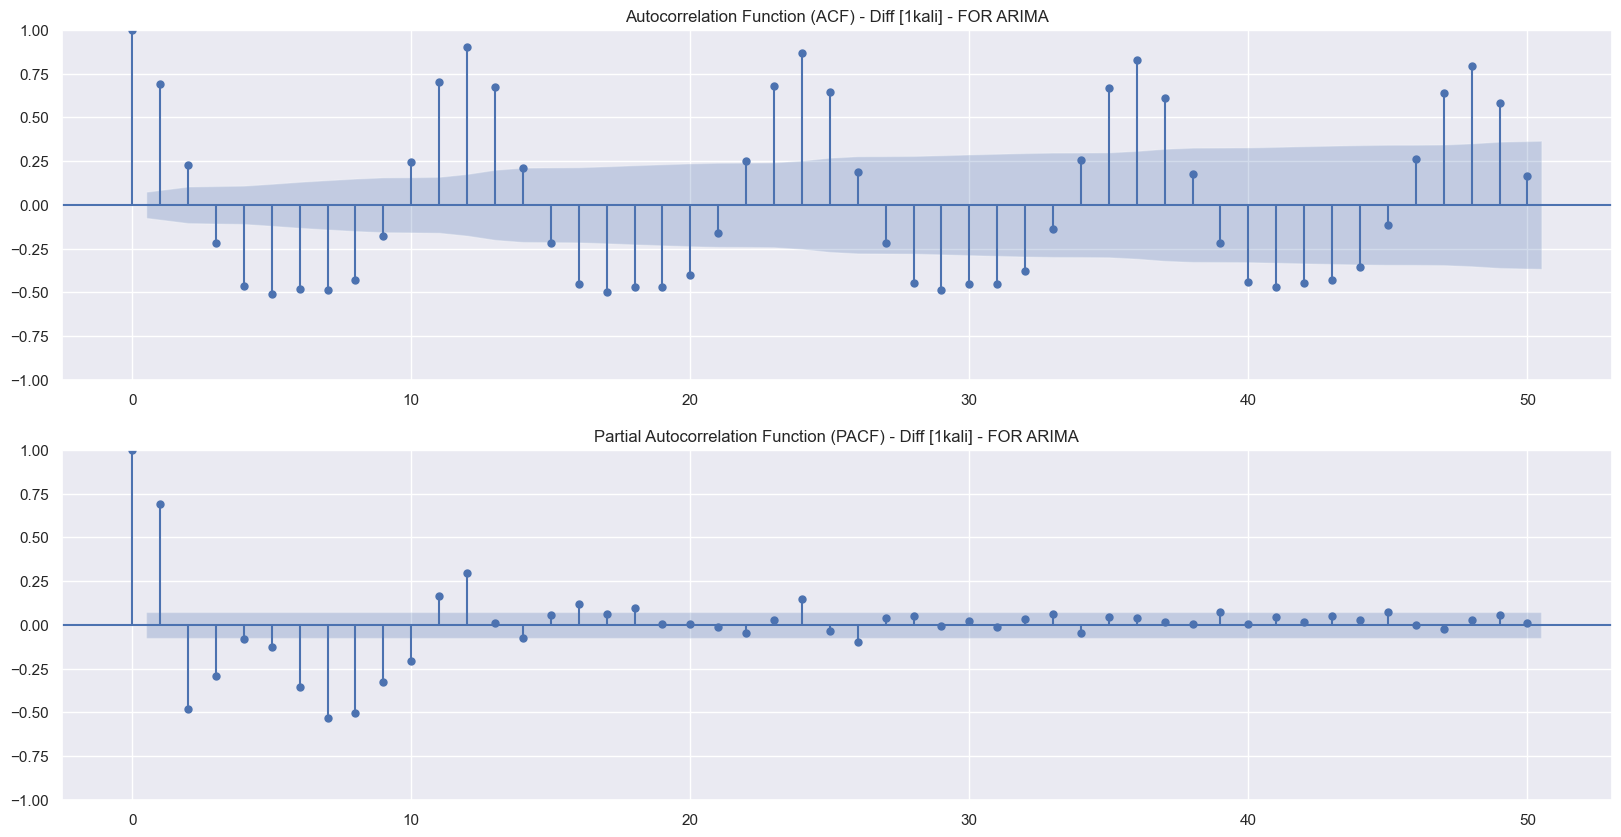

In [81]:
# Define the significance level (usually 0.05 or 0.1) 
significance_level = 0.05

# Create subplots
fig, ax = plt.subplots(2,1,figsize=(20,10))

# ACF plot with significant lines I 
sm.graphics.tsa.plot_acf(df2['Carbon Dioxide (ppm)_Diff [1kali]'].iloc[2:], lags=50, alpha=significance_level, ax=ax[0], ) 
ax[0].set_title('Autocorrelation Function (ACF) - Diff [1kali] - FOR ARIMA')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(df2['Carbon Dioxide (ppm)_Diff [1kali]'].iloc[2:], lags=50, alpha=significance_level, ax=ax[1]) 
ax[1].set_title('Partial Autocorrelation Function (PACF) - Diff [1kali] - FOR ARIMA')

plt.tight_layout 
plt.show()

Pada plot ACF dan PACF diatas, telihat pola seasonal, sehingga jika kita ingin mencari order dari Non Season tidak akan ada Pola yang cocok untuk model. 

Namun jika melihat pola diatas ketika `plot PACF` nya adalah `Cut Off di lag 2`, dan ada `Spike Lag` di setiap lag kelipatan `12` yakni 12 dan 24. maka dapat dipastikan bahwa dari plot diatas meengkonfirmasikan data kita adalah `seasonal data`. Sehingga ARIMA tidak akan cocok untuk data ini. maka menggunakan SARIMA.

Lalu mari coba analisis `plot ACF` diatas. Memiliki model `Diesdown sinusoidal extremely slowly` dan disini sudah dapat disimpulkan bahwa data nya `non stationary data`. Meski telah di differencing dan dicek `UJI-ADF`, namun terbukti bahwa data `tidak Stationer`. Satu hal yang perlu diperhatikan bahwa disini terdapat sebuah `pola signifikan lag` di setiap lag `kelipatan 12` sama dengan `plot ACF` berarti hal tersebut menunjukkan data yang digunakan `lebih cocok` kepada model `SARIMA` daripada `ARIMA`

<blockquote> Tapi mari coba buktikan jika kita memaksakan opini menggunakan `ARIMA` dengan asumsi terdekat adalah `Model AR(2)` karena ACF `Diesdown Sinusoidal not extremely slowly` (Asumsi), dan `PACF Cut off` lag ke-`2`. </blockquote>

`p - > AR - > PACF`
`q - > MA - > ACF`

## diff 12 untuk seasonal (SARIMA)

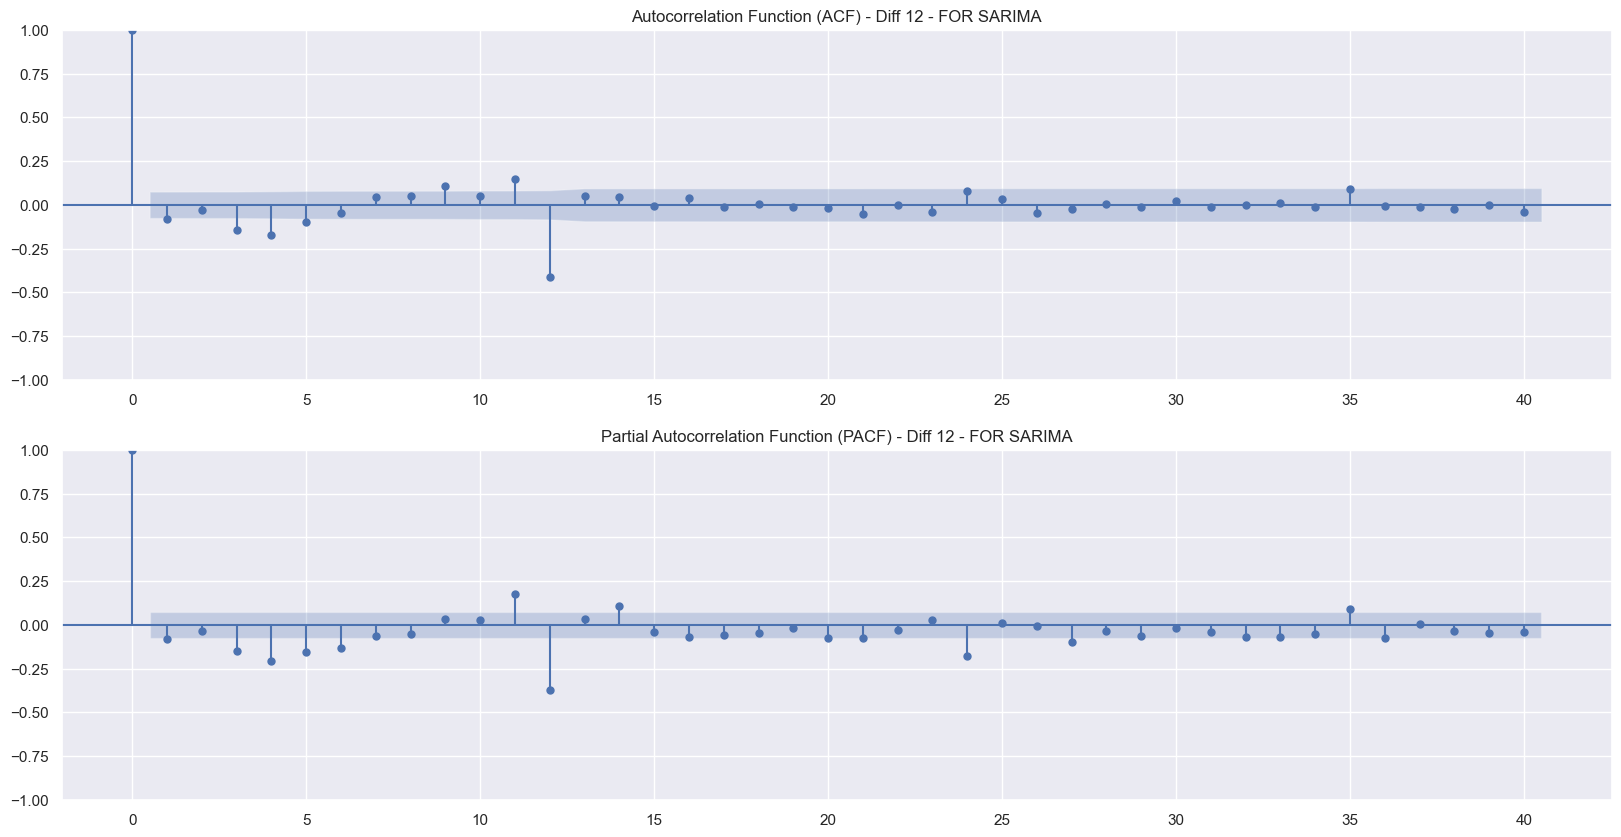

In [82]:
# Define the significance level (usually 0.05 or 0.1) 
significance_level = 0.05

# Create subplots
fig, ax = plt.subplots(2,1,figsize=(20,10))

# ACF plot with significant lines I 
sm.graphics.tsa.plot_acf(df2['Carbon Dioxide (ppm)_Diff-12'].iloc[13:], lags=40, alpha=significance_level, ax=ax[0], ) 
ax[0].set_title('Autocorrelation Function (ACF) - Diff 12 - FOR SARIMA')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(df2['Carbon Dioxide (ppm)_Diff-12'].iloc[13:], lags=40, alpha=significance_level, ax=ax[1]) 
ax[1].set_title('Partial Autocorrelation Function (PACF) - Diff 12 - FOR SARIMA')

plt.tight_layout 
plt.show()

Pada `plot ACF dan PACF` diatas berdasarkan `data diff(12)`, telihat pola `stationary data` dengan seasonal data dengan pola tahunan yakni nilai `m = 12`

Namun jika melihat pola diatas ketika plot PACF nya adalah `Spike Lag pada setiap kelipatan 12` yakni lag `12` dan lag `24`. Lag `36 bisa menjadi uji coba order P` jika hasil belum memuaskan. `P = 2`

Lalu mari coba analisis `plot ACF` diatas. menunjukkan `spike pada lag ke 12 saja`, berarti nnti akan menghasilkan `Q = 1`

# Model Selection

Pilih 3 model(Statistical Methods in Time Series) peramalan dari list sebagai berikut: 

| Model 1   | Model 2   | Model 3   | Model 4   | Model 5   | Model 6   |
|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|
| Naïve | Moving Average | Exponential Smoothing | SARIMA/ARIMA | Time series regression | SARIMAX (Wajib) |

<div style="border-radius:10px; border:#D0C2F0 solid; padding: 15px; background-color: #FFF0F4; font-size:100%; text-align:left">

<h2 align="Center"><font color='#5E5273'>ARIMA (AutoRegressive Integrated Moving Average)</font></h2>

Dalam statistik dan ekonometrika, model Moving Average terintegrasi autoregresif (ARIMA) merupakan generalisasi dari model rata-rata pergerakan autoregresif (ARMA). Kedua model ini disesuaikan dengan data deret waktu untuk pemahaman data yang lebih baik atau memperkirakan poin deret mendatang. Model ARIMA diterapkan ketika data menampilkan non-stasioneritas dalam artian mean.

**ARIMA: Autoregressive + Moving Average + Trend Differencing**

Reference : https://www.kaggle.com/code/tohidyousefi/statistical-methods-in-time-series-arima-sarima#SARIMA(p,-d,-q):-(Seasonal-Autoregressive-Integrated-Moving-Average)

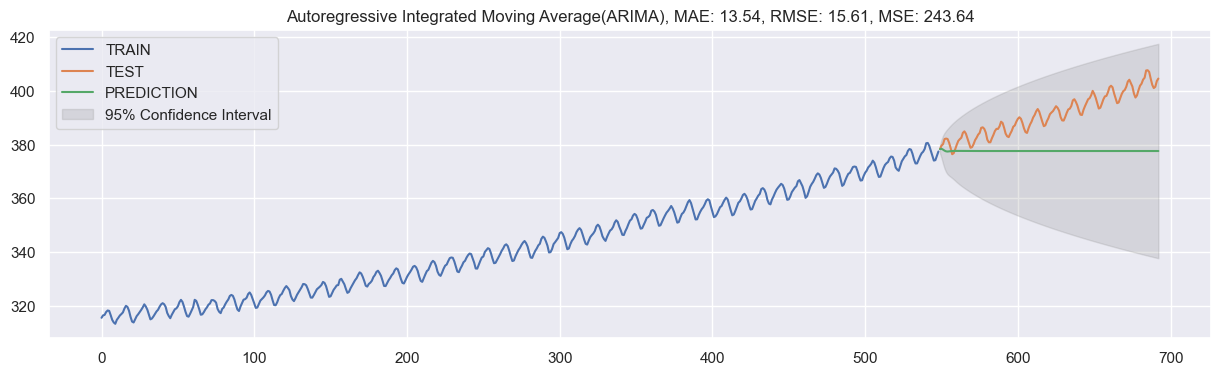

In [83]:
def plot_model(train, test, y_pred, title, confidence_interval=None):
    global mae, mse, rmse
    mae = mean_absolute_error(test, y_pred)
    mse = mean_squared_error(test, y_pred)
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}, MSE: {round(mse, 2)}")
    test.plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    if confidence_interval is not None:
        plt.fill_between(test.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
    plt.legend()
    plt.show()
    plt.show()


def arima_base_model(train, test, p, d, q, step, title="Autoregressive Integrated Moving Average(ARIMA)"):
    global arima_model, y_pred
    arima_model = ARIMA(train, order=(p, d, q)).fit()
    # Forecast
    y_pred = arima_model.forecast(steps=step)
    conf_int = arima_model.get_forecast(steps=step).conf_int(alpha=0.05)  # Confidence interval
    plot_model(train, test, y_pred, title, confidence_interval=conf_int)
    
arima_base_model(train['Carbon Dioxide (ppm)'], test['Carbon Dioxide (ppm)'], p=2, d=1, q=0, step=len(test['Carbon Dioxide (ppm)'])) # Order diambil berdasarkan Lag Lag di Plot PACF

`MAE` (***Mean Absolute Error***): mengukur rata-rata dari selisih absolut antara nilai prediksi dan nilai sebenarnya dalam data. Dalam kasus ini, MAE memiliki nilai sebesar 11.50. Ini berarti rata-rata kesalahan prediksi dari model terhadap data observasi sekitar 1.07 ppm. MAE memberikan gambaran tentang seberapa besar kesalahan rata-rata antara prediksi dan nilai sebenarnya.

`MSE` (***Mean Squared Error***): mengukur rata-rata dari kuadrat perbedaan antara nilai prediksi dan nilai sebenarnya. MSE memiliki nilai sebesar 2.3. Dalam MSE, perbedaan yang lebih besar lebih dipertimbangkan karena kesalahan di kuadrat sebelum dihitung rata-rata, sehingga menyebabkan nilai yang lebih besar dibandingkan dengan MAE.

`RMSE` (***Root Mean Squared Error***): adalah akar kuadrat dari MSE, yang memberikan penilaian kesalahan model dalam unit yang sama dengan data aslinya. Dalam kasus ini, RMSE memiliki nilai sebesar 1.52 ppm. RMSE adalah salah satu metrik evaluasi yang paling sering digunakan karena memberikan indikasi seberapa jauh rata-rata kesalahan model dari nilai sebenarnya.

In [84]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Carbon Dioxide (ppm)   No. Observations:                  549
Model:                   ARIMA(2, 1, 0)   Log Likelihood                -624.469
Date:                  Sat, 13 Jan 2024   AIC                           1254.937
Time:                          13:20:46   BIC                           1267.856
Sample:                               0   HQIC                          1259.987
                                  - 549                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0553      0.044     24.145      0.000       0.970       1.141
ar.L2         -0.5011      0.044    -11.330      0.000      -0.588      -0.414
sigma2         0.5706      0.038     15.176      0.000       0.497       0.644
===================================================================================
Ljung-Box (L1) (Q):                  10.95   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               1.00   Skew:                             0.13
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

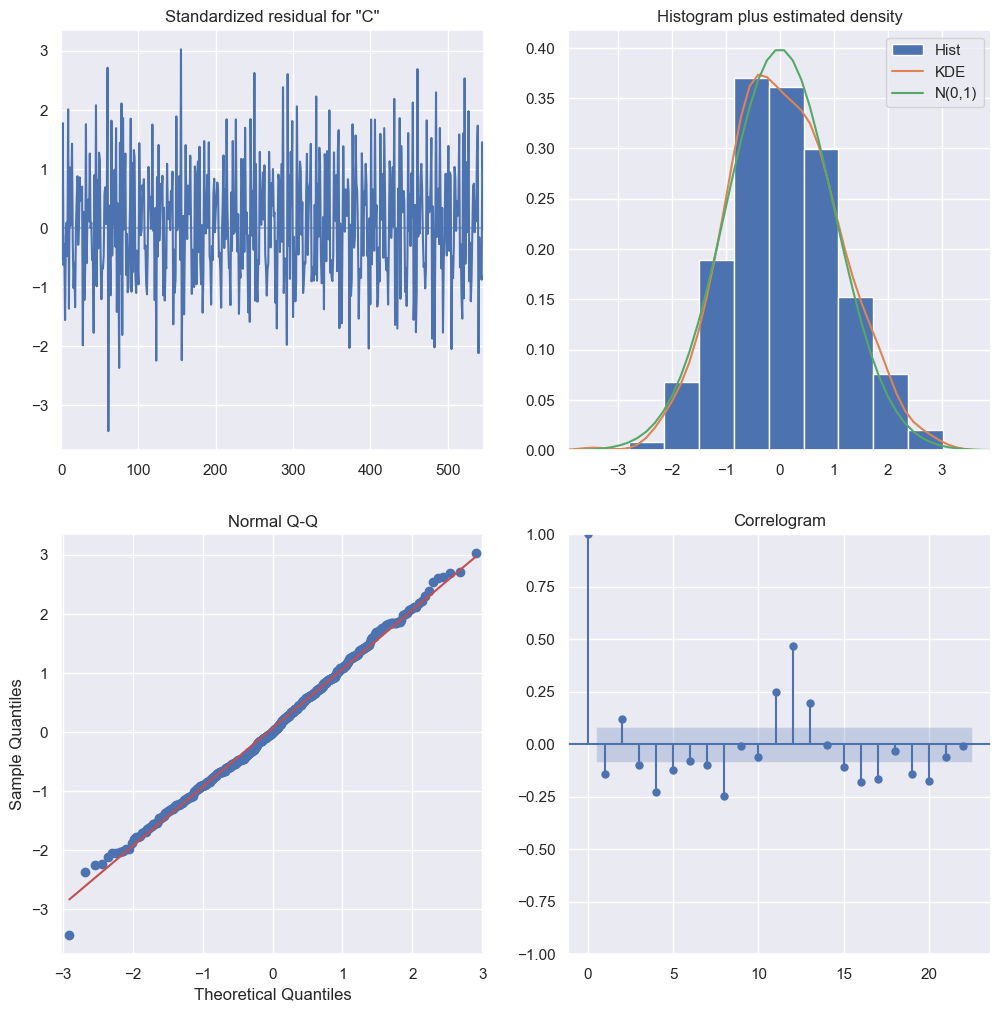

In [85]:
arima_model.plot_diagnostics(figsize = (12, 12), lags = 22)
plt.show()

## ARIMA Model Tuning
Determining Model Grade Based on AIC and BIC Statistics

### Cara 1 - Optimizer Based AIC and BIC

In [86]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    return best_aic, best_params

In [87]:
def arima_model_tuning_aic(train, test, step, title="Model Tuning - Autoregressive Integrated Moving Average"):
    p = d = q = range(0, 4)
    pdq = list(itertools.product(p, d, q))
    
    global best_aic, best_params
    best_aic, best_params = arima_optimizer_aic(train, pdq)
    final_model = ARIMA(train, order=best_params).fit()
    
    # Forecast
    y_pred = final_model.forecast(steps=step)
    conf_int = final_model.get_forecast(steps=step).conf_int(alpha=0.05)  # Confidence interval
    
    # Plotting
    plot_model(train, test, y_pred, title, confidence_interval=conf_int)


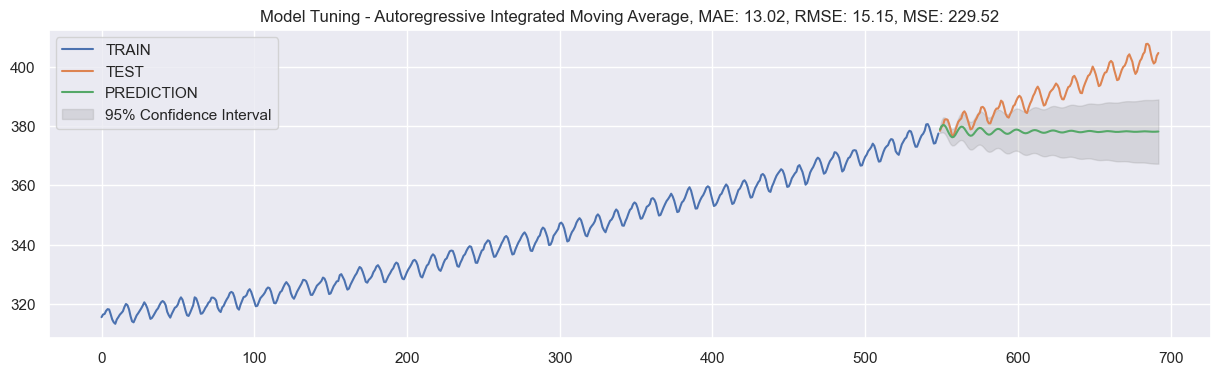

In [88]:
arima_model_tuning_aic(train['Carbon Dioxide (ppm)'], test['Carbon Dioxide (ppm)'], step=len(test['Carbon Dioxide (ppm)']))

In [89]:
best_aic, best_params

(997.013728237341, (3, 1, 3))

### Cara 2 - Optimizer Based MAE

In [90]:
def arima_optimizer_mae(train, test, orders, step):
    best_mae, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            y_pred = arima_model_result.forecast(step)
            mae = mean_absolute_error(test[:step], y_pred)
            if mae < best_mae:
                best_mae, best_params = mae, order
        except Exception as e:
            print(f"Error occurred for order {order}: {e}")
            continue
    return best_mae, best_params

In [91]:
def arima_model_tuning_mae(train, test, step, title="Model Tuning - Autoregressive Integrated Moving Average"):
    p = d = q = range(0, 4)
    pdq = list(itertools.product(p, d, q))
    global best_mae, best_params
    best_mae, best_params = arima_optimizer_mae(train, test, pdq, step)
    final_model = ARIMA(train, order=best_params).fit()
    forecast = final_model.get_forecast(steps=step)
    y_pred = forecast.predicted_mean
    confidence_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

    # Plotting
    plot_model(train, test, y_pred, title, confidence_interval=confidence_int)
    
    
    return best_mae, best_params

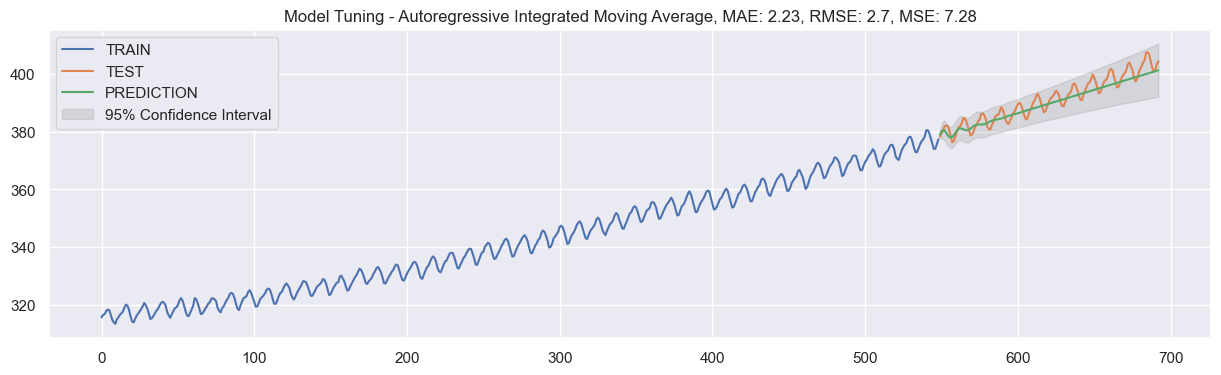

In [92]:
best_mae, best_params = arima_model_tuning_mae(train['Carbon Dioxide (ppm)'], test['Carbon Dioxide (ppm)'], step=len(test['Carbon Dioxide (ppm)']))

In [93]:
best_mae, best_params

(2.2293261588507556, (3, 2, 2))

### Forecast to data Carbon Dioxide (ppm) [not Train Test dataset]

- Jangka pendek `1 Tahun`
- Jangka panjang `5 Tahun`

In [94]:
# Order yang terbaik setelah menguji coba banyak sekali kombinasi Order diatas didapatkan adalah p=3, d=1, q=1 ['order berdasarkan Optimasi Parameter']

In [95]:
best_params = (3, 2, 2)

#### ARIMA Forecast Jangka PANJANG

In [96]:
def arima_final_model(y, best_params, step):
    final_model = ARIMA(y, order=best_params).fit()
    feature_predict = final_model.forecast(steps=step)
    
    # Ambil tanggal terakhir dari DataFrame Anda
    last_date = df2['Date'].iloc[-1]
    
    global forecast_dates
    # Buat range tanggal baru berdasarkan jumlah langkah prediksi
    forecast_dates = pd.date_range(start=last_date, periods=step+1, freq='MS')[1:]  # Langsung mulai dari bulan setelah tanggal terakhir
    
    # Assign variabel untuk axis X dan Y
    x = df2['Date'].iloc[-36:]
    y = df2['Carbon Dioxide (ppm)'].iloc[-36:]
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Original Data')  # Plot data asli
    plt.plot(forecast_dates, feature_predict, color='red', label='Forecast')  # Plot hasil prediksi
    plt.title('ARIMA Forecast Jangka Panjang')
    plt.xlabel('Time')
    plt.ylabel('Carbon Dioxide (ppm)')
    plt.legend()
    
    # Tambahkan teks ke plot
    Tanggal_Awal = str(x.head(1).tolist()[0]).split(' ')[0]
    Tanggal_Akhir = str(x.tail(1).tolist()[0]).split(' ')[0]
    plt.text(df2['Date'].iloc[-35], 413, f'Original Data {Tanggal_Awal} Sampai {Tanggal_Akhir}',  fontsize=12, color='grey')
    plt.text(df2['Date'].iloc[-35], 411.5, f'Forecast 5 Tahun Kedepan',  fontsize=12, color='grey')

    
    plt.show()
    
    return feature_predict

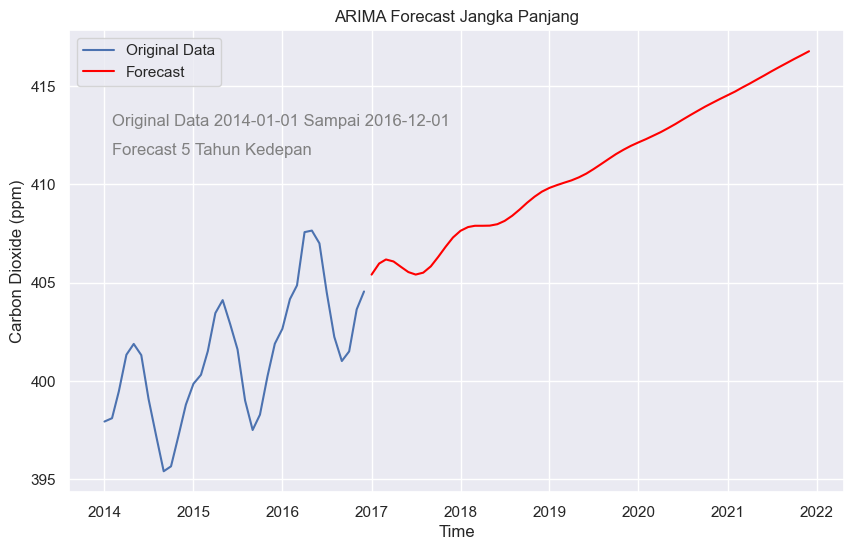

In [97]:
prediction_final = arima_final_model(df2['Carbon Dioxide (ppm)'], best_params, step=60)

In [98]:
# prediction_final

#### ARIMA Forecast Jangka PENDEK

In [99]:
def arima_final_model(y, best_params, step):
    final_model = ARIMA(y, order=best_params).fit()
    feature_predict = final_model.forecast(steps=step)
    
    # Ambil tanggal terakhir dari DataFrame Anda
    last_date = df2['Date'].iloc[-1]
    
    global forecast_dates
    # Buat range tanggal baru berdasarkan jumlah langkah prediksi
    forecast_dates = pd.date_range(start=last_date, periods=step+1, freq='MS')[1:]  # Langsung mulai dari bulan setelah tanggal terakhir
    
    # Assign variabel untuk axis X dan Y
    x = df2['Date'].iloc[-36:]
    y = df2['Carbon Dioxide (ppm)'].iloc[-36:]
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Original Data')  # Plot data asli
    plt.plot(forecast_dates, feature_predict, color='red', label='Forecast')  # Plot hasil prediksi
    plt.title('ARIMA Forecast Jangka Pendek')
    plt.xlabel('Time')
    plt.ylabel('Carbon Dioxide (ppm)')
    plt.legend()
    
    # Tambahkan teks ke plot
    Tanggal_Awal = str(x.head(1).tolist()[0]).split(' ')[0]
    Tanggal_Akhir = str(x.tail(1).tolist()[0]).split(' ')[0]
    plt.text(df2['Date'].iloc[-35], 404.5, f'Original Data {Tanggal_Awal} Sampai {Tanggal_Akhir}',  fontsize=12, color='grey')
    plt.text(df2['Date'].iloc[-35], 403.9, f'Forecast 1 Tahun Kedepan',  fontsize=12, color='grey')

    
    plt.show()
    
    return feature_predict

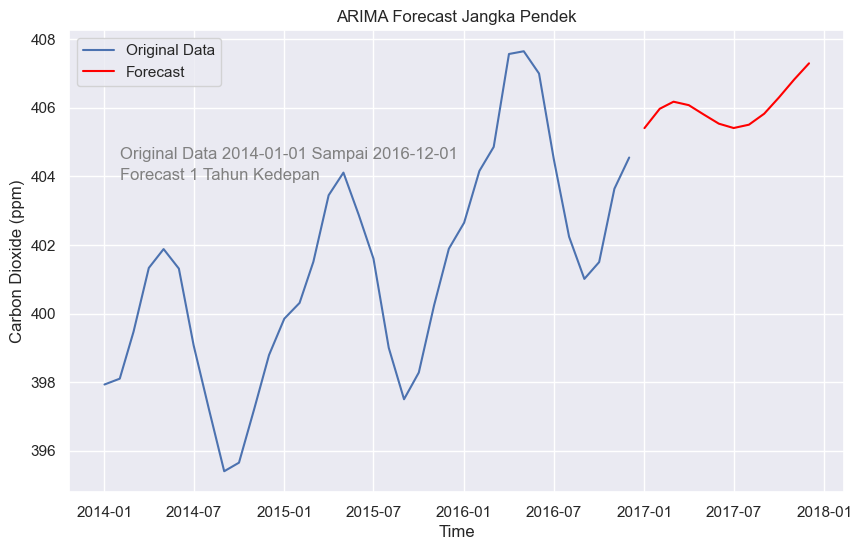

In [100]:
prediction_final = arima_final_model(df2['Carbon Dioxide (ppm)'], best_params, step=12)

In [101]:
# prediction_final

<div style="border-radius:10px; border:#D0C2F0 solid; padding: 15px; background-color: #FFF0F4; font-size:100%; text-align:left">

<h2 align="Center"><font color='#5E5273'>SARIMA (Seasonal ARIMA)</font></h2>

Dalam menentukan parameter `seasonal_order` (sp, sd, sq, s) dalam model SARIMA, nilai `s` adalah periode musiman dari data time series yang ingin Anda modelkan. Berikut adalah beberapa contoh nilai `s` yang umum digunakan:

| Nilai `s` | Deskripsi         |
|:---------:|:------------------:|
| 1         | Tahunan           |
| 4         | Perempat Tahunan  |
| 12        | Bulanan           |
| 52        | Mingguan          |
| 365       | Harian            |

Misalnya, jika Anda memiliki data bulanan, Anda akan menggunakan `s=12` karena ada 12 bulan dalam satu tahun.

Anda dapat memilih nilai `s` berdasarkan periode dari data Anda untuk menyesuaikan model SARIMA dengan pola musiman yang tepat.

Seasonal Autoregressive Integrated Moving Average (SARIMA), also known as Seasonal ARIMA, extends ARIMA to explicitly support univariate time series data with a seasonal component. It introduces three additional hyperparameters to specify the autoregression (AR), differencing (I), and moving average (MA) for the seasonal part of the series, along with an extra parameter for the period of seasonality.

**SARIMA: Autoregressive + Moving Average + Trend Differencing + Seasonal Differencing**

In [102]:
def sarima_base_model(train, test, p, d, q, P, D, Q, m, step, title="Seasonal Autoregressive Integrated Moving-Average(SARIMA)"):
    sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
    
    # Mendapatkan hasil prediksi dan interval kepercayaan
    y_pred_test = sarima_model.get_forecast(step)
    y_pred = y_pred_test.predicted_mean
    confidence_int = y_pred_test.conf_int(alpha=0.05)
    # Plotting
    plot_model(train, test, y_pred, title, confidence_int)

In [103]:
p, d, q = 0, 0, 0 # Non-Seasonal Order
P, D, Q, M = 2, 1, 1, 12 # Seasonal Order

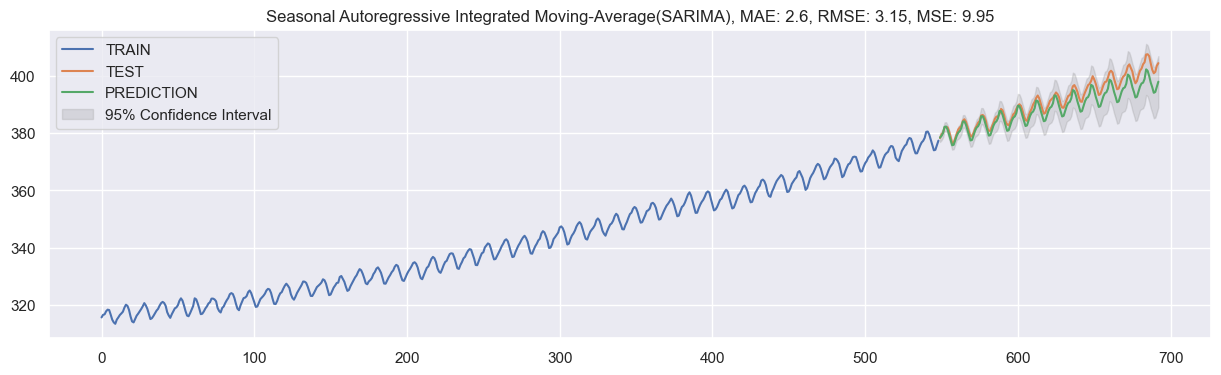

In [104]:
sarima_base_model(train['Carbon Dioxide (ppm)'], test['Carbon Dioxide (ppm)'], p, d, q, P, D, Q, M, step=len(test['Carbon Dioxide (ppm)']))

## SARIMA Model Tuning

### Cara 1 - Optimizer Based AIC and BIC

In [105]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model_results = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                aic = sarimax_model_results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    return best_order, best_seasonal_order

In [106]:
def sarima_model_tuning_aic(train, test, step, title="Model Tuning - Seasonal Autoregressive Integrated Moving-Average"):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    global best_order, best_seasonal_order
    best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
    
    # Latih Model
    final_model = SARIMAX(train, order=(1,0,0), seasonal_order=best_seasonal_order).fit()
    
    # Mendapatkan hasil prediksi dan interval kepercayaan
    y_pred_test = final_model.get_forecast(step)
    y_pred = y_pred_test.predicted_mean
    confidence_int = y_pred_test.conf_int(alpha=0.05)
    
    # Plotting
    plot_model(train, test, y_pred, title, confidence_int)

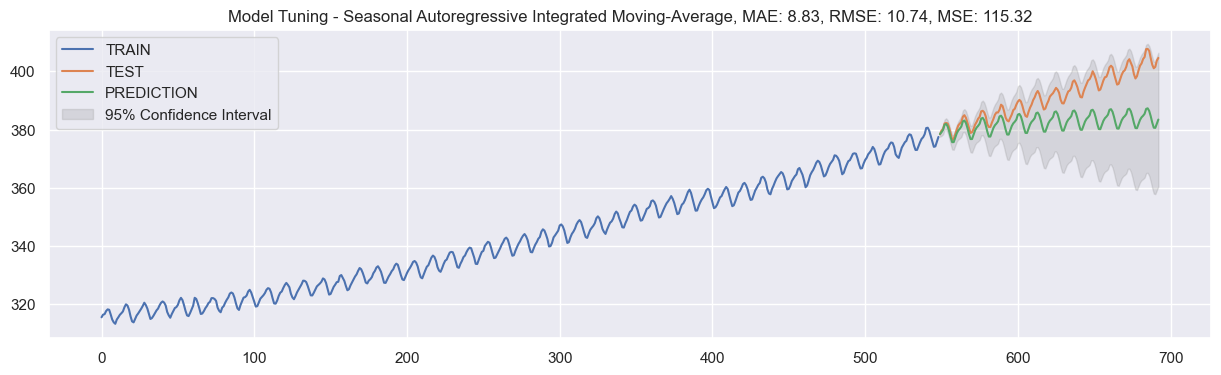

In [107]:
sarima_model_tuning_aic(train['Carbon Dioxide (ppm)'], test['Carbon Dioxide (ppm)'], step=len(test['Carbon Dioxide (ppm)']))

In [108]:
best_order, best_seasonal_order

((1, 1, 0), (0, 1, 1, 12))

### Forecast to data Carbon Dioxide (ppm) [not Train Test dataset]

In [109]:
# Order yang terbaik setelah menguji coba banyak sekali kombinasi Order non seasonal dan order seasonal diatas didapatkan adalah order_Nonseasonal = (0, 0, 0), order_Seasonal = (2, 1, 1, 12) ['order berdasarkan Correlograms']

- Jangka pendek `1 Tahun`
- Jangka panjang `5 Tahun`

In [110]:
best_order_non_seasonal, best_order_seasonal = (p, d, q), (P, D, Q, M)

#### SARIMA Forecast Jangka PANJANG

In [111]:
def sarima_final_model(y, best_order, best_seasonal_order, step):
    final_model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order).fit()
    feature_predict = final_model.get_forecast(step)
    feature_predict = feature_predict.predicted_mean
    
    # Ambil tanggal terakhir dari DataFrame Anda
    last_date = df2['Date'].iloc[-1]

    # Buat range tanggal baru berdasarkan jumlah langkah prediksi
    forecast_dates = pd.date_range(start=last_date, periods=step+1, freq='MS')[1:]  # Langsung mulai dari bulan setelah tanggal terakhir
        
    # Plot data asli dan hasil prediksi
    # Assign variabel untuk axis X dan Y
    x = df2['Date'].iloc[-36:]
    y = df2['Carbon Dioxide (ppm)'].iloc[-36:]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x,y, label='Original Data')  # Plot data asli
    plt.plot(forecast_dates, feature_predict, color='red', label='Forecast')  # Plot hasil prediksi
    plt.title('SARIMA Forecast Jangka Panjang')
    plt.xlabel('Date')
    plt.ylabel('Carbon Dioxide (ppm)')
    plt.legend()
    
    
    # Tambahkan teks ke plot
    Tanggal_Awal = str(x.head(1).tolist()[0]).split(' ')[0]
    Tanggal_Akhir = str(x.tail(1).tolist()[0]).split(' ')[0]
    plt.text(df2['Date'].iloc[-35], 416, f'Original Data {Tanggal_Awal} Sampai {Tanggal_Akhir}',  fontsize=12, color='grey')
    plt.text(df2['Date'].iloc[-35], 414.5, f'Forecast 5 Tahun Kedepan',  fontsize=12, color='grey')
    plt.show()
    
    return feature_predict

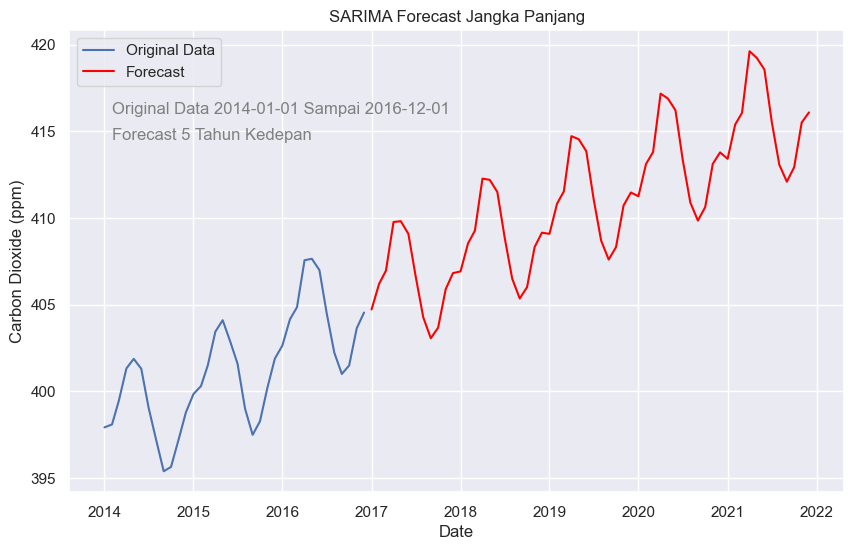

In [112]:
predicted_values = sarima_final_model(df2['Carbon Dioxide (ppm)'], best_order_non_seasonal, best_order_seasonal, step=60)

#### SARIMA Forecast Jangka PENDEK

In [113]:
def sarima_final_model(y, best_order, best_seasonal_order, step):
    final_model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order).fit()
    feature_predict = final_model.get_forecast(step)
    feature_predict = feature_predict.predicted_mean
    
    # Ambil tanggal terakhir dari DataFrame Anda
    last_date = df2['Date'].iloc[-1]

    # Buat range tanggal baru berdasarkan jumlah langkah prediksi
    forecast_dates = pd.date_range(start=last_date, periods=step+1, freq='MS')[1:]  # Langsung mulai dari bulan setelah tanggal terakhir
        
    # Plot data asli dan hasil prediksi
    # Assign variabel untuk axis X dan Y
    x = df2['Date'].iloc[-36:]
    y = df2['Carbon Dioxide (ppm)'].iloc[-36:]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x,y, label='Original Data')  # Plot data asli
    plt.plot(forecast_dates, feature_predict, color='red', label='Forecast')  # Plot hasil prediksi
    plt.title('SARIMA Forecast Jangka PENDEK')
    plt.xlabel('Date')
    plt.ylabel('Carbon Dioxide (ppm)')
    plt.legend()
    
    
    # Tambahkan teks ke plot
    Tanggal_Awal = str(x.head(1).tolist()[0]).split(' ')[0]
    Tanggal_Akhir = str(x.tail(1).tolist()[0]).split(' ')[0]
    plt.text(df2['Date'].iloc[-35], 407, f'Original Data {Tanggal_Awal} Sampai {Tanggal_Akhir}',  fontsize=12, color='grey')
    plt.text(df2['Date'].iloc[-35], 406.2, f'Forecast 1 Tahun Kedepan',  fontsize=12, color='grey')
    plt.show()
    
    return feature_predict

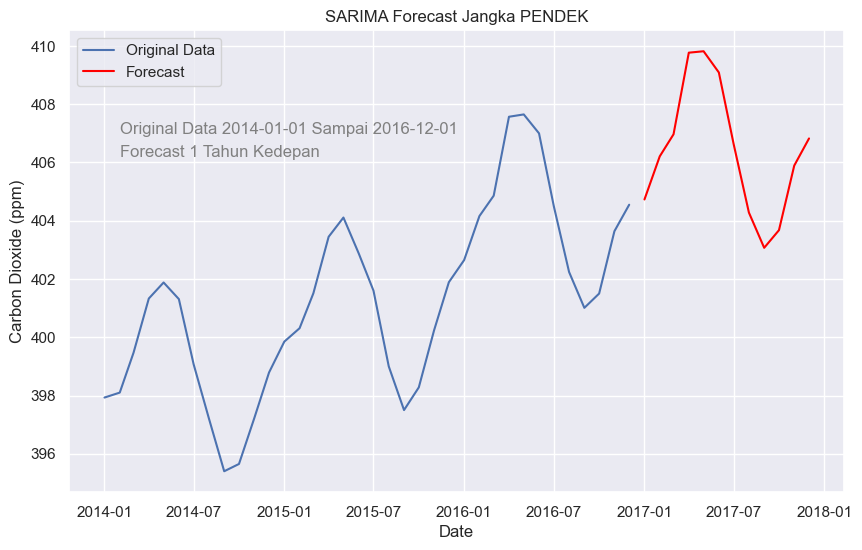

In [114]:
predicted_values = sarima_final_model(df2['Carbon Dioxide (ppm)'], best_order_non_seasonal, best_order_seasonal, step=12)

# SARIMAX

Dalam rangka meningkatkan akurasi prediksi pada data time series, pendekatan yang diadopsi adalah penggabungan informasi dari dua jenis model, yakni regresi linier (OLS) dan ARIMA/SARIMA. Kode yang disajikan terdiri dari beberapa langkah dalam pemodelan dan evaluasi time series data menggunakan regresi linear dengan OLS, serta analisis autoregressive integrated moving average (ARIMA) sebagai bagian dari SARIMAX. Penerapan ini mencoba memanfaatkan keunggulan masing-masing model untuk meningkatkan prediksi. Dimulai dengan regresi linier untuk memahami tren dan hubungan antarvariabel, dilanjutkan dengan ARIMA untuk menangkap sisa-sisa tren dan pola dalam data yang belum terungkapkan oleh regresi. Meskipun tidak secara langsung menggunakan SARIMAX yang menggabungkan variabel eksogen, pendekatan ini mengintegrasikan informasi dari dua model tersebut dalam upaya meningkatkan akurasi prediksi data time series.

## Prepare the dataset

Copy dataset for safety reason

In [115]:
df3 = df2.copy()

In [116]:
df3 = df3[['Date', 'Tahun', 'Carbon Dioxide (ppm)', 'Bulan']] # Select the needed Columns

### Perform one-hot encoding on the 'Bulan' column

In [117]:
df_encoded = pd.get_dummies(df3, columns=['Bulan'], prefix='Bulan')

In [118]:
df_encoded['Trend'] = range(1,len(df_encoded)+1) # Make new columns for trend

In [119]:
missing_data(df_encoded) # The dataframe is clean from Nan value

,Total,Percent
Date,0,0.0000
Tahun,0,0.0000
Carbon Dioxide (ppm),0,0.0000
Bulan_April,0,0.0000
Bulan_August,0,0.0000
Bulan_December,0,0.0000
Bulan_February,0,0.0000
Bulan_January,0,0.0000
Bulan_July,0,0.0000
Bulan_June,0,0.0000


## Split data that is exactly the same as the previous split

In [120]:
# Using Holdut Method ===> Train: 549 Month and Test: 144 Month 
# proporsi (+-) 20% data test & 70% data train
# Membagi data menjadi data pelatihan (train) dan data uji (test) berdasarkan tanggal

# Memilih data pelatihan (train) & data uji (test) berdasarkan rentang tanggal
train_start_date = '1959-01-01'
train_end_date = '2005-01-01'
test_start_date = '2005-01-01'
test_end_date = '2016-12-01'

train_SARIMAX = df_encoded.loc[(df_encoded['Date'] >= train_start_date) & (df_encoded['Date'] < train_end_date)]  
test_SARIMAX = df_encoded[(df_encoded['Date'] >= test_start_date) & (df_encoded['Date'] <= test_end_date)]

In [121]:
# Define X (features) and y (target) for Each Train and Test
X_train = train_SARIMAX[['Trend'] + [f'Bulan_{i}' for i in df3.Bulan.unique()]]
y_train = train_SARIMAX['Carbon Dioxide (ppm)']

X_test = test_SARIMAX[['Trend'] + [f'Bulan_{i}' for i in df3.Bulan.unique()]]
y_test = test_SARIMAX['Carbon Dioxide (ppm)']

In [122]:
print("Jumlah data dalam keseluruhan:", len(df_encoded))
print("Jumlah data dalam set pelatihan:", len(train_SARIMAX))
print("Jumlah data dalam set uji:", len(test_SARIMAX))
print("-"*50)
print(f"Data Train dari tanggal: {train_start_date} - {train_end_date}")
print(f"Data Test dari tanggal: {test_start_date} - {test_end_date}")
print("-"*50)
print(f"Jumlah data dalam X_train: {len(X_train)} y_train: {len(y_train)}")
print(f"Jumlah data dalam X_test: {len(X_test)} y_test: {len(y_test)}")

Jumlah data dalam keseluruhan: 693
Jumlah data dalam set pelatihan: 549
Jumlah data dalam set uji: 144
--------------------------------------------------
Data Train dari tanggal: 1959-01-01 - 2005-01-01
Data Test dari tanggal: 2005-01-01 - 2016-12-01
--------------------------------------------------
Jumlah data dalam X_train: 549 y_train: 549
Jumlah data dalam X_test: 144 y_test: 144


In [123]:
train_SARIMAX.sample(5)

,Date,Tahun,Carbon Dioxide (ppm),Bulan_April,Bulan_August,Bulan_December,Bulan_February,Bulan_January,Bulan_July,Bulan_June,Bulan_March,Bulan_May,Bulan_November,Bulan_October,Bulan_September,Trend
206,1976-06-01,1976,334.3400,0,0,0,0,0,0,1,0,0,0,0,0,207
497,2000-09-01,2000,366.6200,0,0,0,0,0,0,0,0,0,0,0,1,498
459,1997-07-01,1997,364.4700,0,0,0,0,0,1,0,0,0,0,0,0,460
246,1979-10-01,1979,333.8600,0,0,0,0,0,0,0,0,0,0,1,0,247
450,1996-10-01,1996,359.6100,0,0,0,0,0,0,0,0,0,0,1,0,451


## Time Series Regression [OLS - Ordinary least squares]

In [124]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [125]:
# Fit the model
model = sm.OLS(y_train, X_train) # Ordinary least squares
result = model.fit()

### Check Summary of the Model

In [126]:
# Print the regression summary
print(result.summary())

                             OLS Regression Results                             
Dep. Variable:     Carbon Dioxide (ppm)   R-squared:                       0.990
Model:                              OLS   Adj. R-squared:                  0.989
Method:                   Least Squares   F-statistic:                     4274.
Date:                  Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                          13:22:05   Log-Likelihood:                -1127.0
No. Observations:                   549   AIC:                             2280.
Df Residuals:                       536   BIC:                             2336.
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Trend               0.

karena pengingkatan paling tinggi pada pola data asli ada di `bulan April, Mei, Juni, Juli` jadi wajar `coef` nya `tinggi` disana. dan `rendah` di `bulan September, Oktober`

### Plot The Predict & Actual Value Based On `Test Data`

Mean Squared Error: 79.71966718199575
Root Mean Squared Error: 8.928587076463764


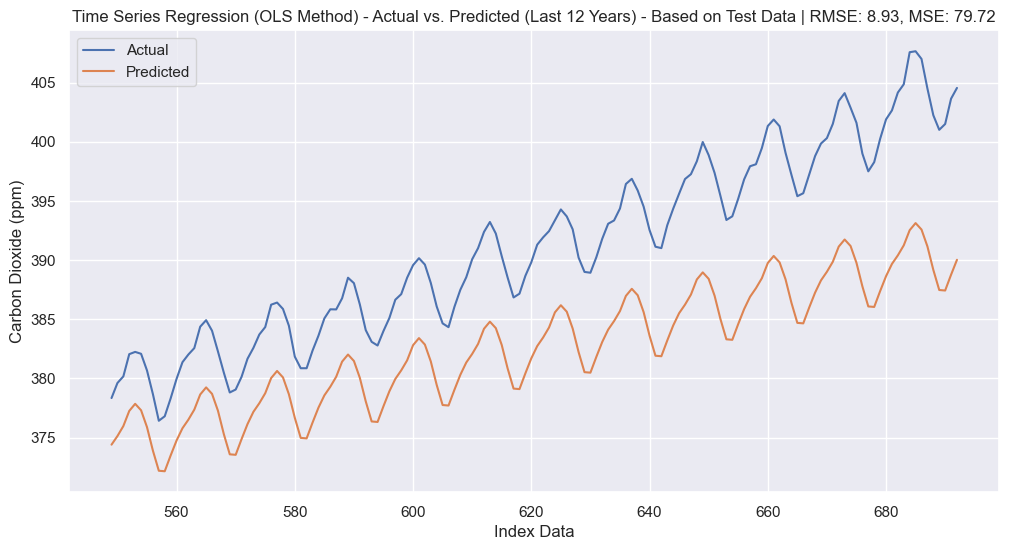

In [127]:
# Make predictions on the test set
predictions_test = result.predict(X_test)

# Evaluate the model
mse_test = mean_squared_error(y_test, predictions_test)
rmse_test = np.sqrt(mse_test)
print(f'Mean Squared Error: {mse_test}')
print(f'Root Mean Squared Error: {rmse_test}')

# Plot the actual vs. predicted values for the last 12 Years
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions_test, label='Predicted')
plt.title(f'Time Series Regression (OLS Method) - Actual vs. Predicted (Last 12 Years) - Based on Test Data | RMSE: {round(rmse_test, 2)}, MSE: {round(mse_test, 2)}')
plt.xlabel('Index Data')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.show()

### Plot The Predict & Actual Value Based On `Train Data`

Mean Squared Error: 3.5530483542388596
Root Mean Squared Error: 8.928587076463764


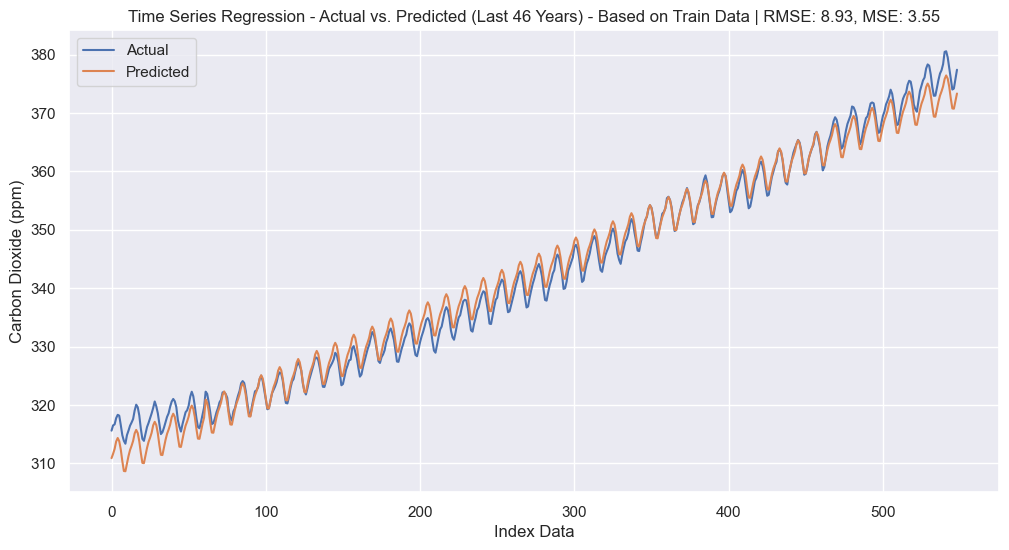

In [128]:
# Make predictions on the test set
predictions_train = result.predict(X_train)

# Evaluate the model
mse_train = mean_squared_error(y_train, predictions_train)
rmse_train = np.sqrt(mse_test)
print(f'Mean Squared Error: {mse_train}')
print(f'Root Mean Squared Error: {rmse_train}')

# Plot the actual vs. predicted values for the last 12 Years
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Actual')
plt.plot(y_train.index, predictions_train, label='Predicted')
plt.title(f'Time Series Regression - Actual vs. Predicted (Last 46 Years) - Based on Train Data | RMSE: {round(rmse_train, 2)}, MSE: {round(mse_train, 2)}')
plt.xlabel('Index Data')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.show()

## SARIMAX [Seasonal ARIMA with Exogenous Regressors]

In [129]:
residuals = result.resid  # mengambil residu dari model ols

In [130]:
residuals_df = pd.DataFrame({'Residuals': residuals})

In [131]:
residuals_df.head()

,Residuals
0,4.7127
1,4.8874
2,4.2112
3,4.0012
4,3.9713


Nilai residu dari model regresi linier (OLS), residu mengacu pada perbedaan antara nilai aktual dari variabel dependen (target) dengan nilai yang diprediksi oleh model untuk setiap observasi dalam data.

$ \text{Residual} = \text{Actual value} - \text{Predicted value} $

Residu menggambarkan sejauh mana model tidak mampu menjelaskan variasi dalam data. Jika residu kecil atau mendekati nol, itu menunjukkan bahwa model dapat memprediksi dengan tepat. Namun, jika residu besar, ini menunjukkan bahwa model tidak dapat menjelaskan variasi dalam data dengan baik.

### ACF PACF dari Residu (Sebelum Differencing)

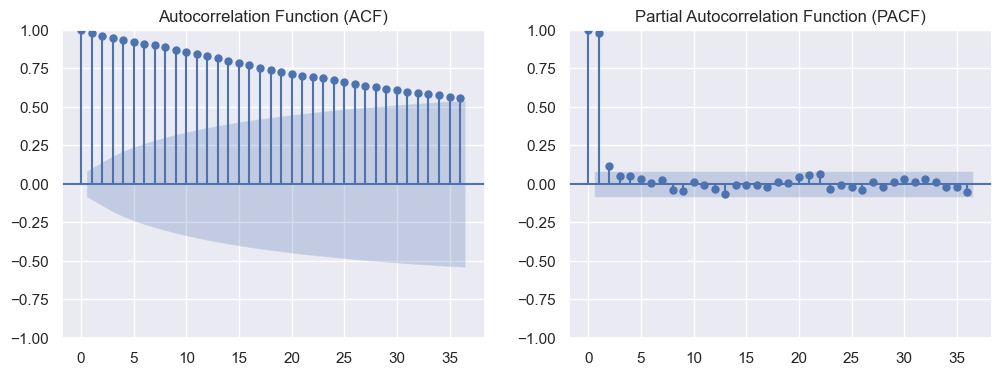

In [132]:
# Define the significance level (usually 0.05 or 0.1) 
significance_level = 0.05

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot with significant lines I 
sm.graphics.tsa.plot_acf(residuals_df['Residuals'], lags=36, alpha=significance_level, ax=ax1) 
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(residuals_df['Residuals'], lags=36, alpha=significance_level, ax=ax2) 
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout 
plt.show()

### Uji Dickey-Fuller

Dickey-Fuller Test Results:
Result: [Terima H0] Non-Stationary (H0: non-stationary, p-value: 0.53)


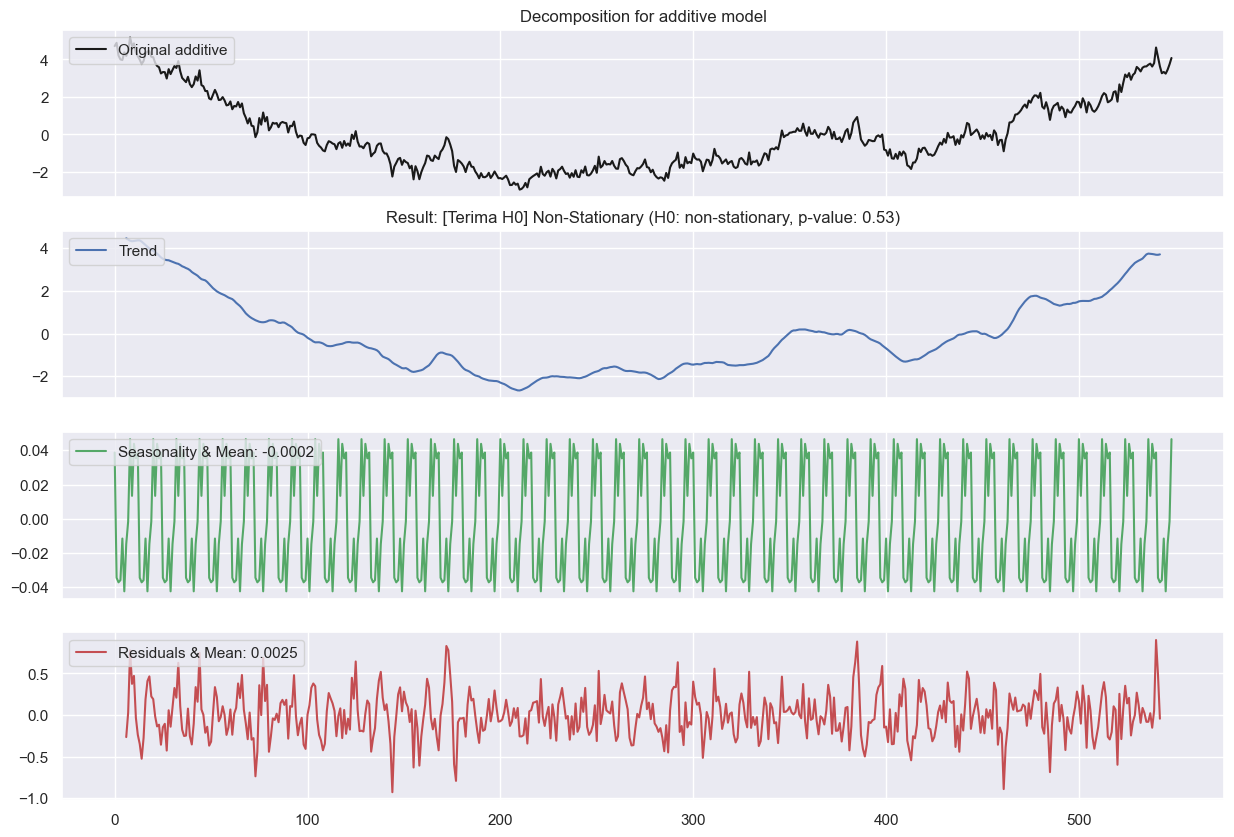

In [133]:
ts_decompose(residuals_df['Residuals'])

### Differencing Residu Data

Data Tidak Stationer maka harus melakukan differencing

In [134]:
residuals_df['residu_diff_1'] = residuals_df['Residuals'].diff(1)

In [135]:
residuals_df['residu_diff_12'] = residuals_df['residu_diff_1'].diff(12)

In [136]:
residuals_df.head()

,Residuals,residu_diff_1,residu_diff_12
0,4.7127,NaN,NaN
1,4.8874,0.1747,NaN
2,4.2112,-0.6762,NaN
3,4.0012,-0.2100,NaN
4,3.9713,-0.0299,NaN


###  ACF PACF dari Residu (Setelah Differencing)

MA itu di ACF, AR nya di PACF

`p - > AR - > PACF`
`q - > MA - > ACF`

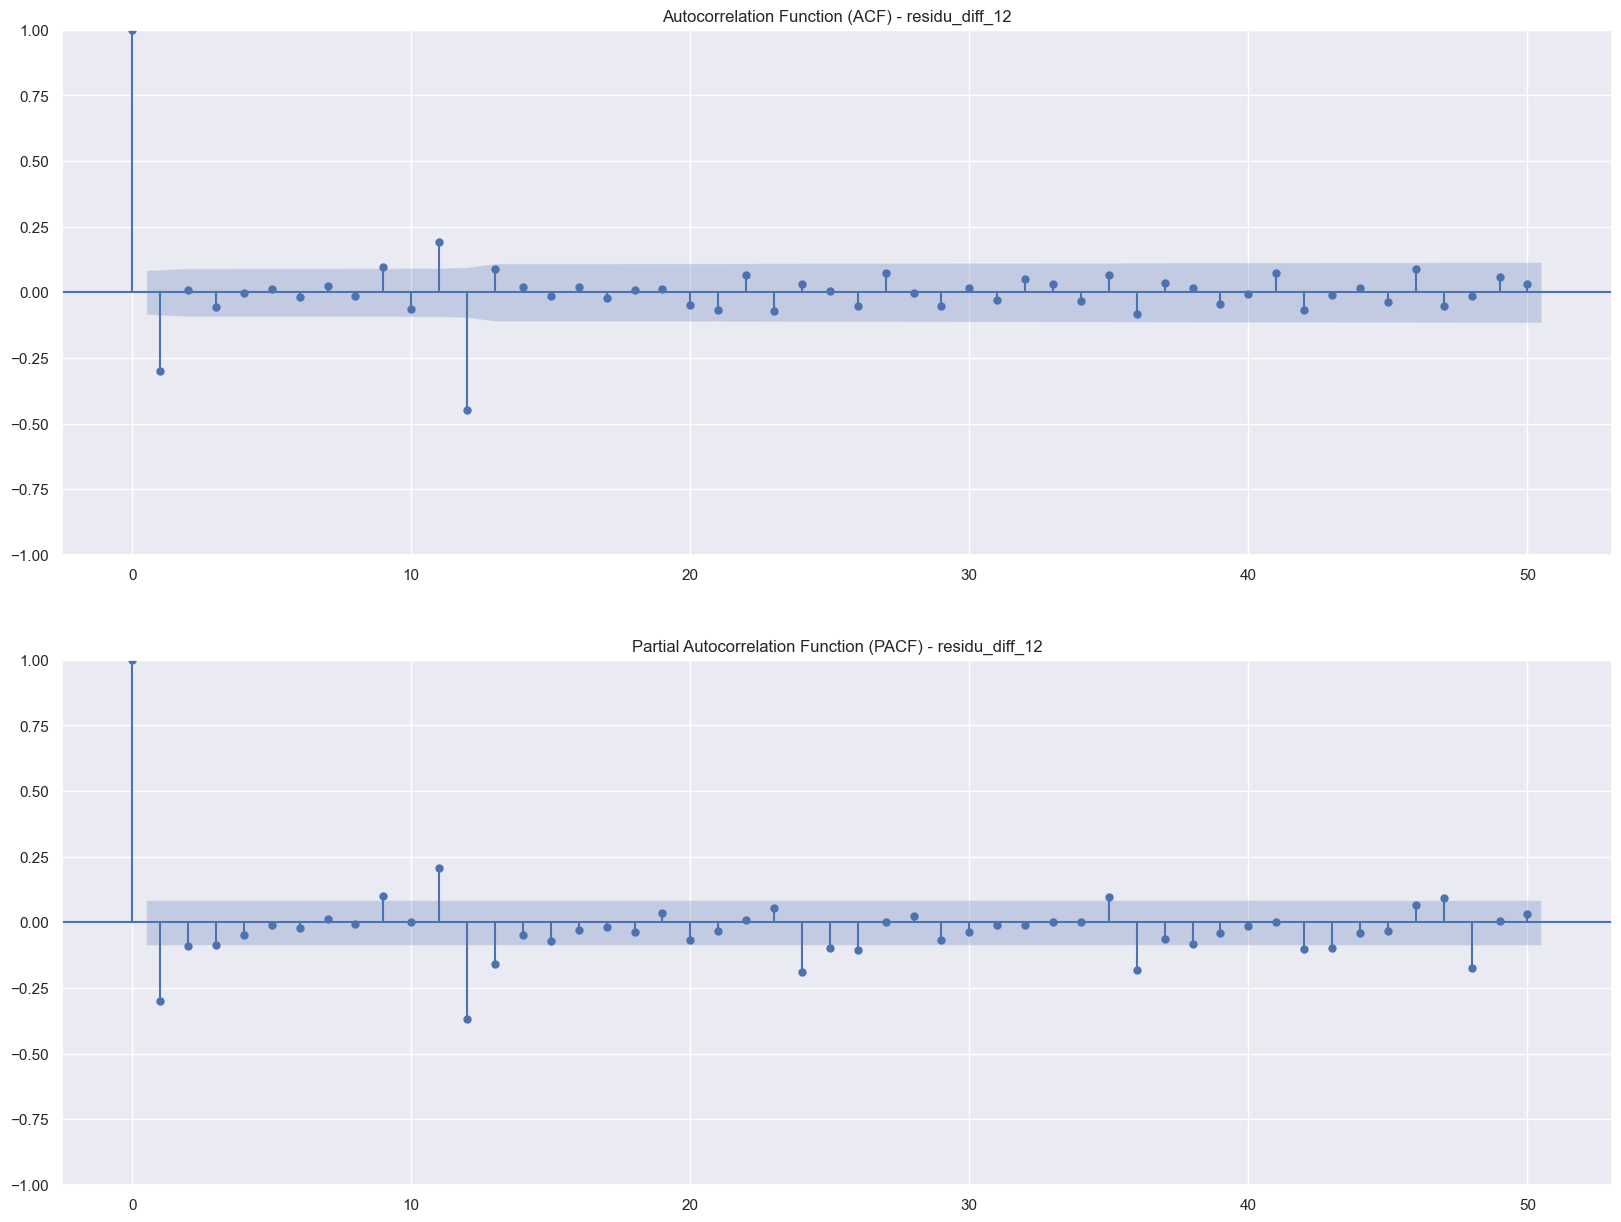

In [137]:
# Define the significance level (usually 0.05 or 0.1) 
significance_level = 0.05

# Create subplots
fig, ax = plt.subplots(2,1,figsize=(20,15))

# ACF plot with significant lines I 
sm.graphics.tsa.plot_acf(residuals_df['residu_diff_12'].iloc[13:], lags=50, alpha=significance_level, ax=ax[0], ) 
ax[0].set_title('Autocorrelation Function (ACF) - residu_diff_12')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(residuals_df['residu_diff_12'].iloc[13:], lags=50, alpha=significance_level, ax=ax[1]) 
ax[1].set_title('Partial Autocorrelation Function (PACF) - residu_diff_12')

plt.tight_layout 
plt.show()

### Model SARIMAX

In [138]:
model = ARIMA(residuals_df['Residuals'], order = (1,1,1), seasonal_order = (4,1,1,12)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        Residuals   No. Observations:                  549
Model:             ARIMA(1, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -104.410
Date:                          Sat, 13 Jan 2024   AIC                            224.821
Time:                                  13:22:15   BIC                            259.094
Sample:                                       0   HQIC                           238.229
                                          - 549                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1812      0.122      1.481      0.139      -0.059       0.421
ma.L1         -0.4869      0.111     -4.371      0.000      -0.705      -0.269
ar.S.L12       0.0148      0.063      0.234      0.815      -0.109       0.139
ar.S.L24      -0.0231      0.057     -0.406      0.685      -0.134       0.088
ar.S.L36      -0.0960      0.056     -1.704      0.088      -0.206       0.014
ar.S.L48      -0.0445      0.055     -0.803      0.422      -0.153       0.064
ma.S.L12      -0.8355      0.049    -17.042      0.000      -0.932      -0.739
sigma2         0.0838      0.005     16.120      0.000       0.074       0.094
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.80   Prob(JB):                         0.87
Heteroskedasticity (H):               0.94   Skew:                            -0.06
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

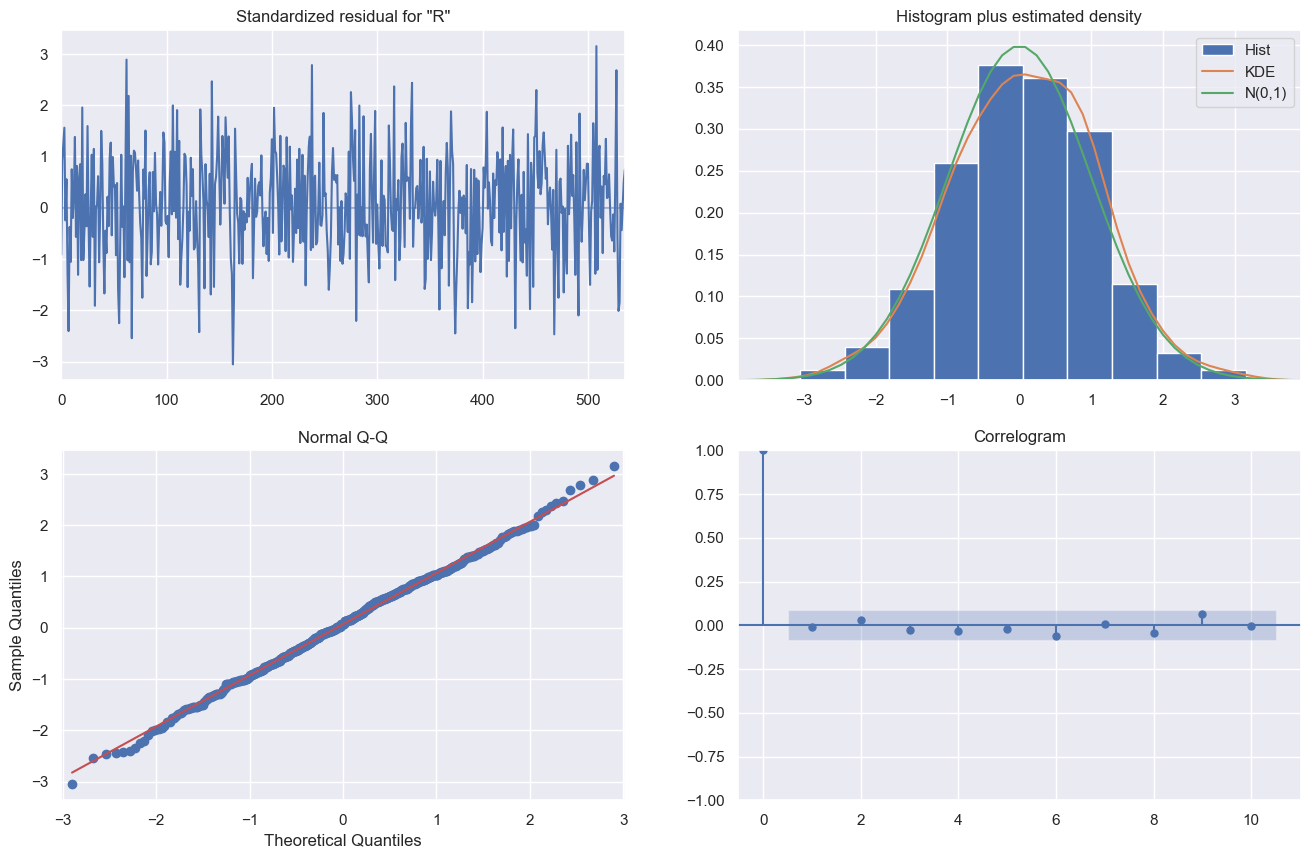

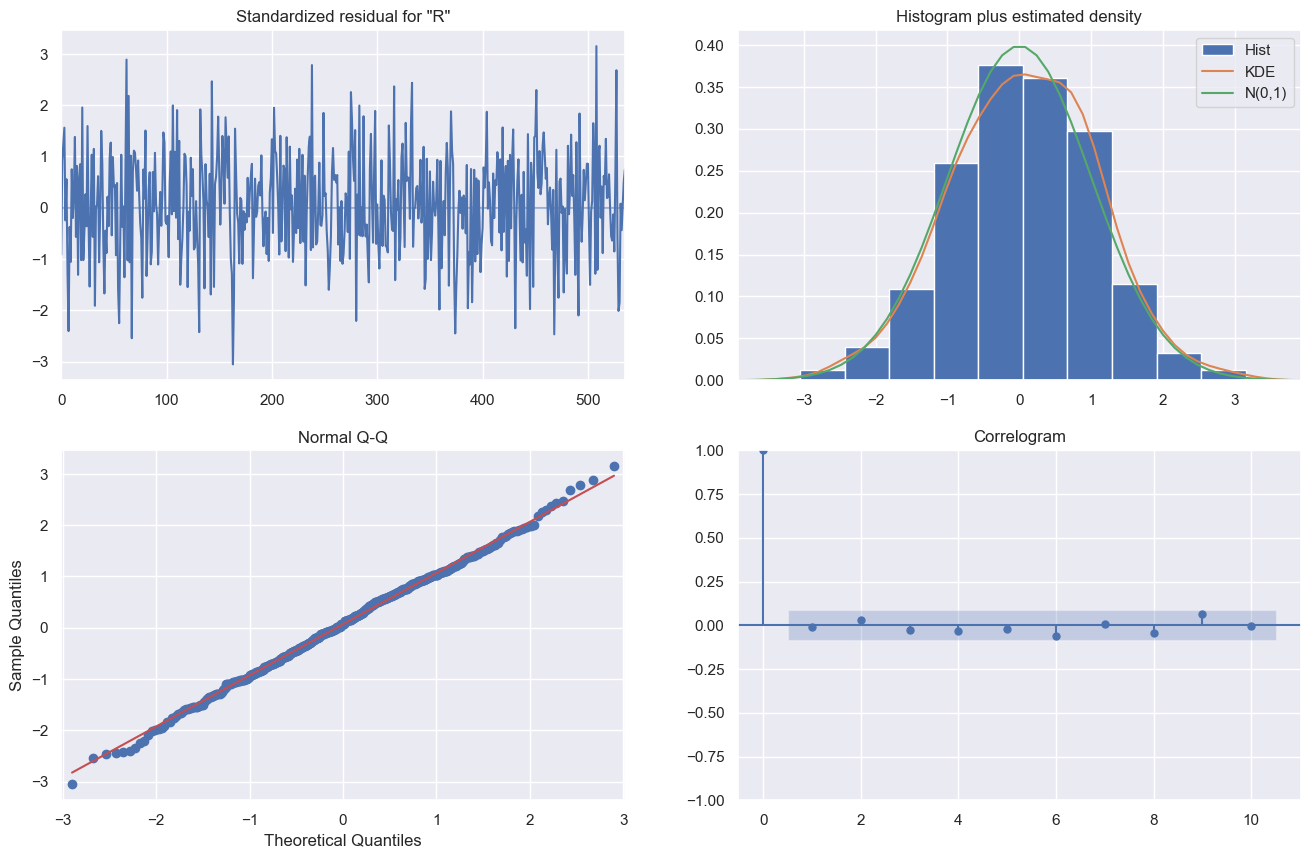

In [139]:
model.plot_diagnostics(figsize = (16,10))

In [140]:
forecast = model.get_forecast(steps = 144).summary_frame(alpha = 0.5) # step 144 karena menyesuaikan dengan Y_test

In [141]:
forecast.sample(5)

Residuals,mean,mean_se,mean_ci_lower,mean_ci_upper
582,4.6375,1.2648,3.7844,5.4907
606,5.4079,1.7945,4.1975,6.6182
551,4.0524,0.3979,3.7840,4.3208
630,6.1646,2.3435,4.5839,7.7452
642,6.5408,2.6360,4.7629,8.3187


In [142]:
et = forecast['mean']

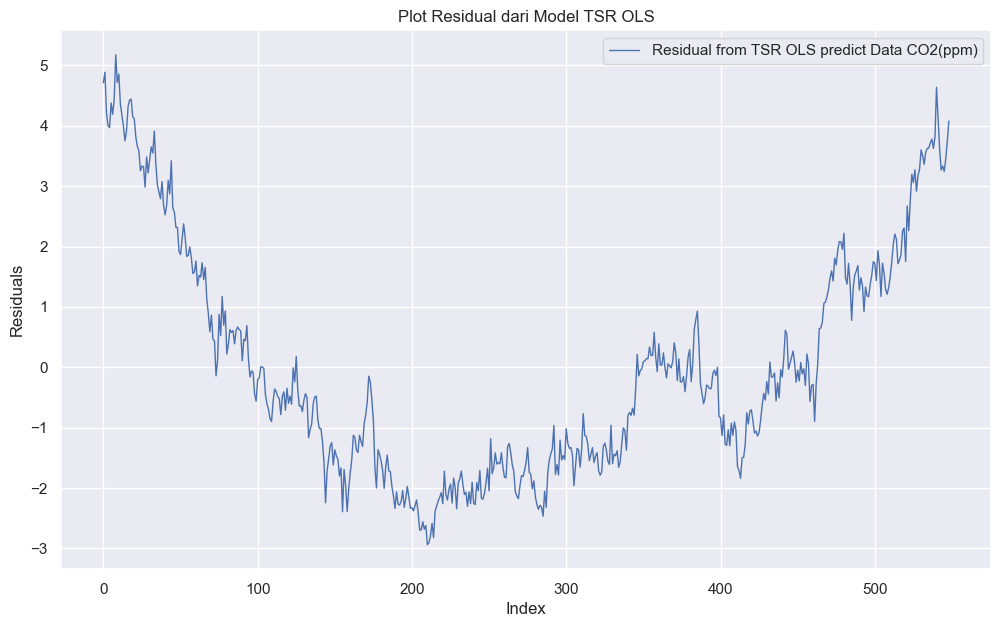

In [143]:
import matplotlib.pyplot as plt

# Data residual
# residuals = residuals_df['Residuals'].iloc[525:]
residuals = residuals_df['Residuals']
index = residuals.index

# Plot
plt.figure(figsize=(12, 7))
plt.plot(index, residuals, linestyle='-', linewidth = 1, color='b', label = 'Residual from TSR OLS predict Data CO2(ppm)')
# plt.plot(et.index, et, linestyle='-', linewidth = 1, color='g', label = 'Residual OLS Forecast by SARIMA')

# plt.title('Plot real Residual Data dan predicted residual')
plt.title('Plot Residual dari Model TSR OLS')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

Menggunakan `model Regresi Linier (OLS)` dan kemudian menghitung `residu`, dan kemudian menggunakan model `SARIMA` pada `residu` tersebut untuk menghasilkan prediksi yang disesuaikan. Lalu melakukan `SARIMAX` seperti `zt = predictions_test + et` dimana `predictions_test mengacu pada hasil prediksi TSR OLS terhadap Data test`, dan `et mengacu pada forecast SARIMA` maka tahap ini adalah bagian dari proses menggabungkan dua model tersebut dalam usaha untuk meningkatkan performa prediksi secara mendalam dan menyeluruh.

In [144]:
zt = predictions_test + et # Make predictions on the SARIMAX model Hybrid OLS dan SARIMA

In [145]:
zt

549   378.4267
550   379.1730
551   380.0238
552   381.4850
553   381.9351
554   381.3150
555   379.7964
556   377.7352
557   375.9658
558   376.1290
559   377.6124
560   379.0550
561   380.1061
562   380.8717
563   381.7126
564   383.1060
565   383.5943
566   382.9819
567   381.4732
568   379.3867
569   377.6573
570   377.7981
571   379.3090
572   380.7708
573   381.8196
574   382.6036
575   383.3944
576   384.7381
577   385.2754
578   384.7367
579   383.2540
580   381.1320
581   379.4626
582   379.5679
583   381.0773
584   382.5346
585   383.5838
586   384.3672
587   385.1507
588   386.5322
589   387.0629
590   386.5202
591   385.0236
592   382.9059
593   381.2474
594   381.3466
595   382.8560
596   384.3168
597   385.3649
598   386.1382
599   386.9317
600   388.3502
601   388.8609
602   388.2962
603   386.7858
604   384.6776
605   383.0131
606   383.1156
607   384.6284
608   386.0945
609   387.1400
610   387.9105
611   388.7095
612   390.1355
613   390.6397
614   390.0673
615   388.

### Plot The Predict & Actual Value Based On `Test Data`

Mean Squared Error: 8.47934424796329
Root Mean Squared Error: 2.911931360448472


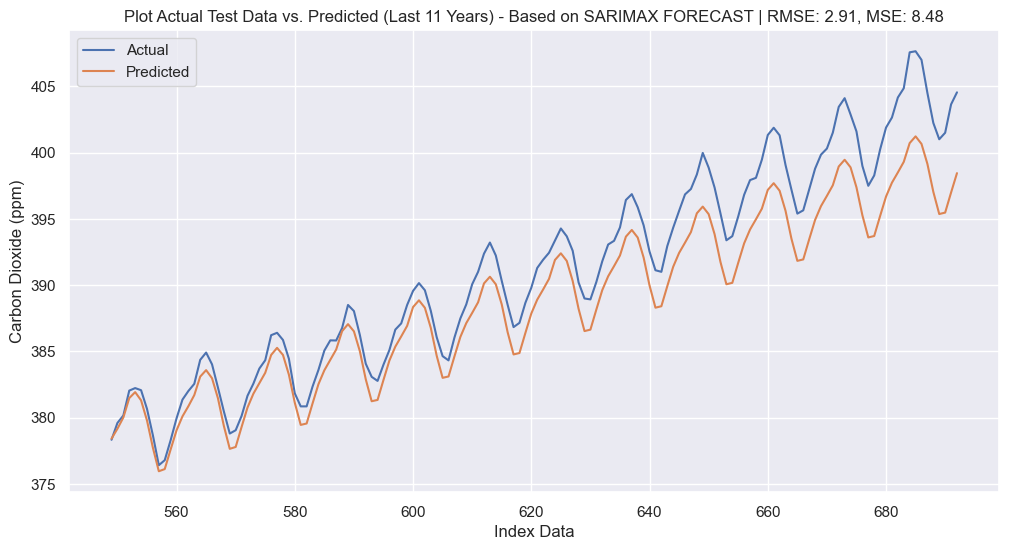

In [146]:
# Evaluate the model
mse_test = mean_squared_error(y_test, zt)
rmse_test = np.sqrt(mse_test)
print(f'Mean Squared Error: {mse_test}')
print(f'Root Mean Squared Error: {rmse_test}')

# Plot the actual vs. predicted values for the last 11 Years
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(zt.index, zt, label='Predicted')
plt.title(f'Plot Actual Test Data vs. Predicted (Last 11 Years) - Based on SARIMAX FORECAST | RMSE: {round(rmse_test, 2)}, MSE: {round(mse_test, 2)}')
plt.xlabel('Index Data')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.show()

### Forecast to data Carbon Dioxide (ppm) [not Train Test dataset]

In [147]:
# Order yang terbaik setelah menguji coba banyak sekali kombinasi Order non seasonal dan order seasonal diatas didapatkan adalah order_Nonseasonal = (0, 0, 0), order_Seasonal = (2, 1, 1, 12) ['order berdasarkan Correlograms']

- Jangka pendek `1 Tahun`
- Jangka panjang `5 Tahun`

### Membuat Data kedepannya untuk di forecast

Membuat Data yang lebih jauh dari X_test dan Y_test nya kita coba estimasi menggunakan model OLS yang sudah ada sebelumnya

#### Mengulangi tren ke depan (12 bulan kedepan dan 5 tahun kedepan)

In [148]:
import calendar

# Mengulangi tren ke depan (12 bulan kedepan dan 5 tahun kedepan)
trends = []
for i in range(694, 694 + 5 * 12):  # 12 bulan kedepan + 5 tahun kedepan (dalam bulan)
    trends.append(i)

# Membuat DataFrame untuk prediksi ke depan
future_trend = pd.DataFrame({'Trend': trends})

# Menambahkan kolom "Bulan" yang berisi nama bulan terurut
future_trend['Bulan'] = future_trend['Trend'].apply(lambda x: calendar.month_name[(x - 694) % 12 + 1])

#### One Hot Encoding untuk Kolom bulan

In [149]:
future_trend_encoded = pd.get_dummies(future_trend, columns=['Bulan'], prefix='Bulan')

In [150]:
future_trend_encoded.head(10)

,Trend,Bulan_April,Bulan_August,Bulan_December,Bulan_February,Bulan_January,Bulan_July,Bulan_June,Bulan_March,Bulan_May,Bulan_November,Bulan_October,Bulan_September
0,694,0,0,0,0,1,0,0,0,0,0,0,0
1,695,0,0,0,1,0,0,0,0,0,0,0,0
2,696,0,0,0,0,0,0,0,1,0,0,0,0
3,697,1,0,0,0,0,0,0,0,0,0,0,0
4,698,0,0,0,0,0,0,0,0,1,0,0,0
5,699,0,0,0,0,0,0,1,0,0,0,0,0
6,700,0,0,0,0,0,1,0,0,0,0,0,0
7,701,0,1,0,0,0,0,0,0,0,0,0,0
8,702,0,0,0,0,0,0,0,0,0,0,0,1
9,703,0,0,0,0,0,0,0,0,0,0,1,0


#### Data Siap digunakan dan dipisahkan menjadi 1 tahun dan 5 tahun

In [151]:
# Melanjutkan 12 bulan ke depan dari data yang ada
future_1_year = future_trend_encoded.head(12)

# Melanjutkan 5 tahun ke depan dari data yang ada
future_5_years = future_trend_encoded

#### OLS Predict ke 1 tahun kedepan

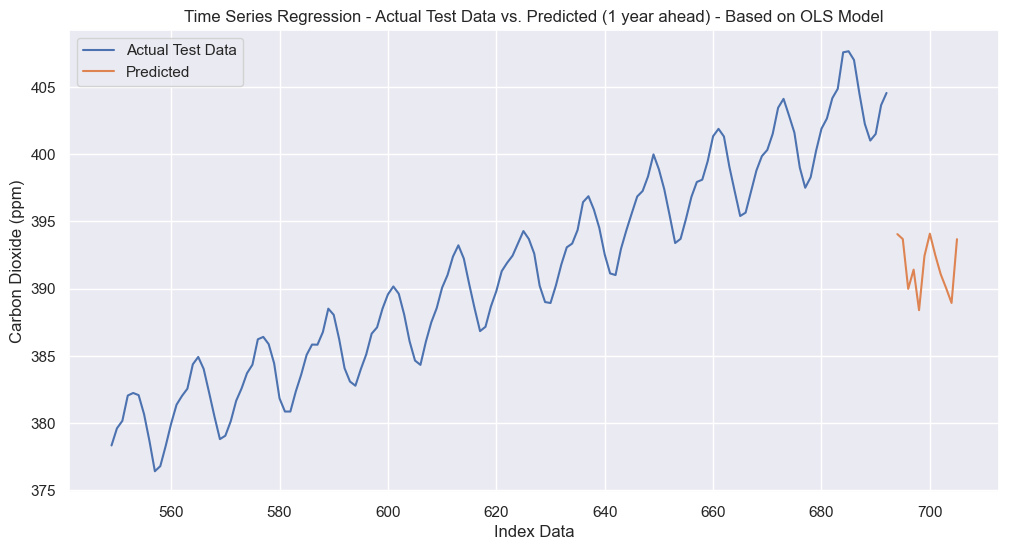

In [152]:
# Make predictions on the test set
predictions_1_year = result.predict(future_1_year)

# Plot the actual vs. predicted values for the last 12 Month
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Test Data')
plt.plot(future_1_year.Trend, predictions_1_year, label='Predicted')
plt.title('Time Series Regression - Actual Test Data vs. Predicted (1 year ahead) - Based on OLS Model')
plt.xlabel('Index Data')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.show()

#### OLS Predict ke 5 tahun kedepan

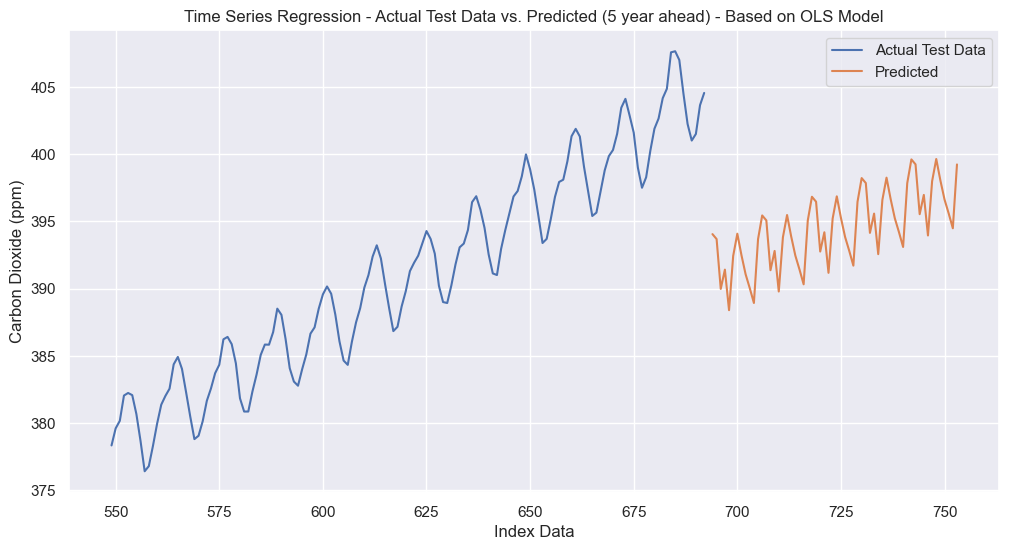

In [153]:
# Make predictions on the test set
predictions_5_year = result.predict(future_5_years)

# Plot the actual vs. predicted values for the last 5 Years
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Test Data')
plt.plot(future_5_years.Trend, predictions_5_year, label='Predicted')
plt.title('Time Series Regression - Actual Test Data vs. Predicted (5 year ahead) - Based on OLS Model')
plt.xlabel('Index Data')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.show()

#### Residual of Sarima predict 1 Tahun dan 5 Tahun (Jangka Pendek dan Panjang)

In [154]:
# model.summary()

In [155]:
forecast_next_data = model.get_forecast(steps = 204).summary_frame(alpha = 0.5) 

# step 204 karena menyesuaikan dengan Y_test dan forecastting jangka pendek dan panjang. 144 bulan untuk data test + 60 untuk 5 tahun kedapan

In [156]:
forecast_next_data

Residuals,mean,mean_se,mean_ci_lower,mean_ci_upper
549,4.0270,0.2894,3.8317,4.2222
550,4.0479,0.3523,3.8102,4.2855
551,4.0524,0.3979,3.7840,4.3208
552,4.2336,0.4376,3.9385,4.5288
553,4.0839,0.4737,3.7644,4.4034
554,4.0099,0.5073,3.6677,4.3520
555,3.9145,0.5387,3.5511,4.2778
556,3.8403,0.5684,3.4569,4.2237
557,3.7702,0.5966,3.3678,4.1726
558,3.9760,0.6236,3.5554,4.3966


In [157]:
et_forecast_next_data = forecast_next_data["mean"].iloc[144:]

In [158]:
et_1_tahun_kedepan = et_forecast_next_data.head(12).reset_index(drop = True) # Error untuk 1 tahun setelah data test tanggal 2016-12-01

In [159]:
et_5_tahun_kedepan = et_forecast_next_data.reset_index(drop = True) # Error untuk 5 tahun setelah data test tanggal 2016-12-01

#### Predict value of Sarimax Model

In [160]:
zt_Sarimax_1_Tahun = predictions_1_year + et_1_tahun_kedepan # Make predictions on the SARIMAX model Hybrid OLS dan SARIMA

In [161]:
# zt_Sarimax_1_Tahun

In [162]:
zt_Sarimax_5_Tahun = predictions_5_year + et_5_tahun_kedepan # Make predictions on the SARIMAX model Hybrid OLS dan SARIMA

In [163]:
# zt_Sarimax_5_Tahun

#### SARIMAX Predict ke 1 tahun kedepan

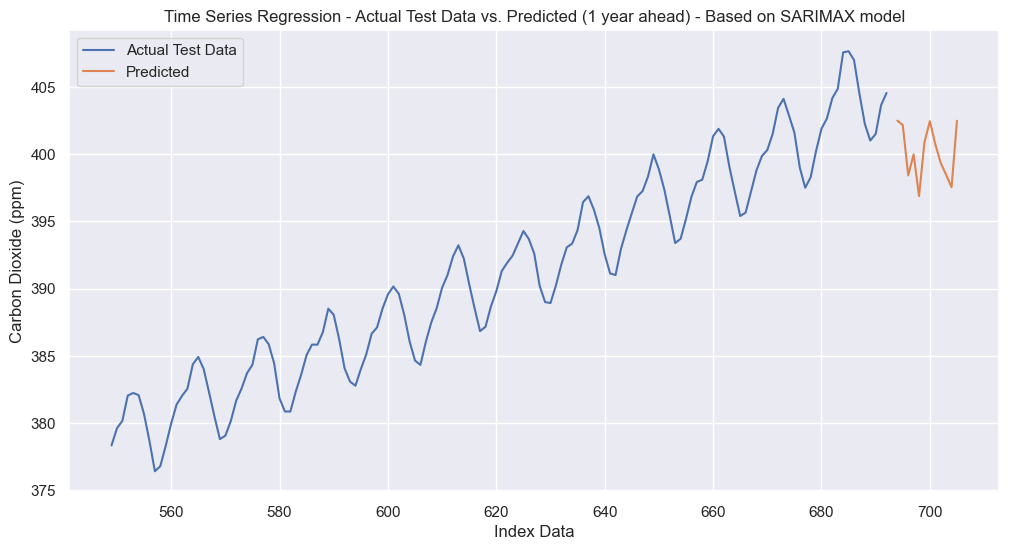

In [164]:
# Plot the actual vs. predicted values for the last 12 Month
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Test Data')
plt.plot(future_1_year.Trend, zt_Sarimax_1_Tahun, label='Predicted')
plt.title('Time Series Regression - Actual Test Data vs. Predicted (1 year ahead) - Based on SARIMAX model')
plt.xlabel('Index Data')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.show()

#### SARIMAX Predict ke 5 tahun kedepan

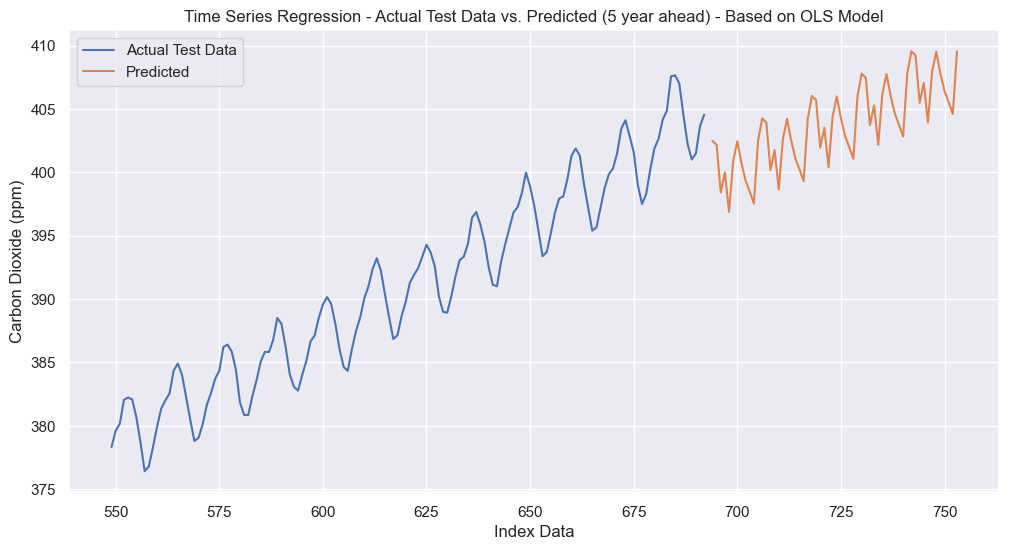

In [165]:
# Plot the actual vs. predicted values for the last 5 Years
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Test Data')
plt.plot(future_5_years.Trend, zt_Sarimax_5_Tahun, label='Predicted')
plt.title('Time Series Regression - Actual Test Data vs. Predicted (5 year ahead) - Based on OLS Model')
plt.xlabel('Index Data')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.show()

- https://www.kaggle.com/code/poiupoiu/how-to-use-sarimax#Make-features1
- https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting#15.-SARIMAX-model-with-exogeneous-variables-
- https://www.kaggle.com/code/ludovicocuoghi/covid19-italy-analysis-and-forecasting#SARIMAX
- https://www.kaggle.com/code/poiupoiu/how-to-use-sarimax#SARIMA-model